In [1]:
configuration = {"Case": 'Multi-Blobs',
                 "Field": 'rho, Phi, T',
                 "Field_Mixing": 'Channel',
                 "Type": '2D Time',
                 "Epochs": 0,
                 "Batch Size": 4,
                 "Optimizer": 'Adam',
                 "Learning Rate": 0.005,
                 "Scheduler Step": 100,
                 "Scheduler Gamma": 0.5,
                 "Activation": 'GELU',
                 "Normalisation Strategy": 'Min-Max. Single',
                 "Instance Norm": 'No',
                 "Log Normalisation":  'No',
                 "Physics Normalisation": 'Yes',
                 "T_in": 10,    
                 "T_out": 40,
                 "Step": 5,
                 "Modes": 16,
                 "Width_time":32, #FNO
                 "Width_vars": 0, #U-Net
                 "Variables":3, 
                 "Noise":0.0, 
                 "Loss Function": 'LP Loss',
                 "Spatial Resolution": 1,
                 "Temporal Resolution": 1,
                #  "UQ": 'Dropout',
                #  "Dropout Rate": 0.9
                 }

In [2]:
from simvue import Run
run = Run(mode='disabled')
run.init(folder="/FNO_MHD", tags=['FNO', 'MHD', 'JOREK', 'Multi-Blobs', 'MultiVariable'], metadata=configuration)

True

In [3]:
import os 
CODE = ['FNO_multiple.py']
# Save code files
for code_file in CODE:
    if os.path.isfile(code_file):
        run.save(code_file, 'code')
    elif os.path.isdir(code_file):
        run.save_directory(code_file, 'code', 'text/plain', preserve_path=True)
    else:
        print('ERROR: code file %s does not exist' % code_file)

In [4]:
import numpy as np
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import cm 

import operator
from functools import reduce
from functools import partial
from collections import OrderedDict

import time 
from timeit import default_timer
from tqdm import tqdm 

torch.manual_seed(0)
np.random.seed(0)

In [5]:
path = os.getcwd()
data_loc = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
# model_loc = os.path.dirname(os.path.dirname(os.getcwd()))
file_loc = os.getcwd()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
##################################
#Normalisation Functions 
##################################


# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=-1.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x


    def cuda(self):
        self.a = self.a.cuda()
        self.b = self.b.cuda()

    def cpu(self):
        self.a = self.a.cpu()
        self.b = self.b.cpu()

# #normalization, rangewise but single value. 


# normalization, rangewise but single value.
class MinMax_Normalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(MinMax_Normalizer, self).__init__()
        min_u = torch.min(x[:, 0, :, :, :])
        max_u = torch.max(x[:, 0, :, :, :])

        self.a_u = (high - low) / (max_u - min_u)
        self.b_u = -self.a_u * max_u + high

        min_v = torch.min(x[:, 1, :, :, :])
        max_v = torch.max(x[:, 1, :, :, :])

        self.a_v = (high - low) / (max_v - min_v)
        self.b_v = -self.a_v * max_v + high

        min_p = torch.min(x[:, 2, :, :, :])
        max_p = torch.max(x[:, 2, :, :, :])

        self.a_p = (high - low) / (max_p - min_p)
        self.b_p = -self.a_p * max_p + high

    def encode(self, x):
        s = x.size()

        u = x[:, 0, :, :, :]
        u = self.a_u * u + self.b_u

        v = x[:, 1, :, :, :]
        v = self.a_v * v + self.b_v

        p = x[:, 2, :, :, :]
        p = self.a_p * p + self.b_p

        x = torch.stack((u, v, p), dim=1)

        return x

    def decode(self, x):
        s = x.size()

        u = x[:, 0, :, :, :]
        u = (u - self.b_u) / self.a_u

        v = x[:, 1, :, :, :]
        v = (v - self.b_v) / self.a_v

        p = x[:, 2, :, :, :]
        p = (p - self.b_p) / self.a_p

        x = torch.stack((u, v, p), dim=1)

        return x

    def cuda(self):
        self.a_u = self.a_u.cuda()
        self.b_u = self.b_u.cuda()

        self.a_v = self.a_v.cuda()
        self.b_v = self.b_v.cuda()

        self.a_p = self.a_p.cuda()
        self.b_p = self.b_p.cuda()

    def cpu(self):
        self.a_u = self.a_u.cpu()
        self.b_u = self.b_u.cpu()

        self.a_v = self.a_v.cpu()
        self.b_v = self.b_v.cpu()

        self.a_p = self.a_p.cpu()
        self.b_p = self.b_p.cpu()


        

# #normalization, rangewise but across the full domain 
# class MinMax_Normalizer(object):
#     def __init__(self, x, low=-1.0, high=1.0):
#         super(MinMax_Normalizer, self).__init__()
#         mymin = torch.min(x)
#         mymax = torch.max(x)

#         self.a = (high - low)/(mymax - mymin)
#         self.b = -self.a*mymax + high

#     def encode(self, x):
#         s = x.size()
#         x = x.reshape(s[0], -1)
#         x = self.a*x + self.b
#         x = x.view(s)
#         return x

#     def decode(self, x):
#         s = x.size()
#         x = x.reshape(s[0], -1)
#         x = (x - self.b)/self.a
#         x = x.view(s)
#         return x

#     def cuda(self):
#         self.a = self.a.cuda()
#         self.b = self.b.cuda()

#     def cpu(self):
#         self.a = self.a.cpu()
#         self.b = self.b.cpu()

In [7]:
##################################
# Loss Functions
##################################

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [8]:
x_grid = np.arange(0, 106)
y_grid = np.arange(0, 106)
S = 106 #Grid Size
size_x = S
size_y = S


modes = configuration['Modes']
width_time = configuration['Width_time']
width_vars = configuration['Width_vars']
output_size = configuration['Step']

batch_size = configuration['Batch Size']

batch_size2 = batch_size

t1 = default_timer()

T_in = configuration['T_in']
T = configuration['T_out']
step = configuration['Step']
num_vars = configuration['Variables']

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, num_vars):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.num_vars = num_vars

        self.scale = (1 / (in_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, num_vars, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, num_vars, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bivxy,iovxy->bovxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, self.num_vars, x.size(-2), x.size(-1) // 2 + 1,
                             dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv3d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv3d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, num_vars):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.num_vars = num_vars

        self.conv = SpectralConv2d(self.width, self.width, self.modes1, self.modes2, self.num_vars)
        self.mlp = MLP(self.width, self.width, self.width)
        self.w = nn.Conv3d(self.width, self.width, 1)
        self.b = nn.Conv3d(2, self.width, 1)

    def forward(self, x, grid):
        x1 = self.conv(x)
        x1 = self.mlp(x1)
        x2 = self.w(x)
        x3 = self.b(grid)
        x = x1 + x2 + x3
        x = F.gelu(x)
        return x

In [11]:
class FNO_multi(nn.Module):
    def __init__(self,T_in, step, num_vars, modes1, modes2, width_vars, width_time):
        super(FNO_multi, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous T_in timesteps + 2 locations (u(t-T_in, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=x_discretistion, y=y_discretisation, c=T_in)
        output: the solution of the next timestep
        output shape: (batchsize, x=x_discretisation, y=y_discretisatiob, c=step)
        """
        self.T_in = T_in
        self.step = step 
        self.num_vars = num_vars
        self.modes1 = modes1
        self.modes2 = modes2
        self.width_vars = width_vars
        self.width_time = width_time

        self.fc0_time = nn.Linear(self.T_in + 2, self.width_time)

        # self.padding = 8 # pad the domain if input is non-periodic

        self.f0 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f1 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f2 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f3 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f4 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f5 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)

        # self.norm = nn.InstanceNorm2d(self.width)
        self.norm = nn.Identity()

        self.fc1_time = nn.Linear(self.width_time, 256)
        self.fc2_time = nn.Linear(256, self.step)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)

        x = self.fc0_time(x)
        x = x.permute(0, 4, 1, 2, 3)
        grid = grid.permute(0, 4, 1, 2, 3)
        # x = self.dropout(x)

        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x0 = self.f0(x, grid)
        x = self.f1(x0, grid)
        x = self.f2(x, grid) + x0
        x1 = self.f3(x, grid)
        x = self.f4(x1, grid)
        x = self.f5(x, grid) + x1

        # x = self.dropout(x)

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic

        x = x.permute(0, 2, 3, 4, 1)
        x = x

        x = self.fc1_time(x)
        x = F.gelu(x)
        # x = self.dropout(x)
        x = self.fc2_time(x)

        return x

    # Using x and y values from the simulation discretisation
    def get_grid(self, shape, device):
        batchsize, num_vars, size_x, size_y = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(9.5, 10.5, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1, 1).repeat([batchsize, num_vars, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(-0.5, 0.5, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y, 1).repeat([batchsize, num_vars, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

    ## Arbitrary grid discretisation
    # def get_grid(self, shape, device):
    #     batchsize, size_x, size_y = shape[0], shape[1], shape[2]
    #     gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    #     gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
    #     gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
    #     gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
    #     return torch.cat((gridx, gridy), dim=-1).to(device)

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [12]:
################################################################
# Loading Data 
################################################################

In [13]:
data = data_loc + '/Data/MHD_multi_blobs.npz'
# data = data_loc + '/Data/FNO_MHD_data_multi_blob_2000_T50.npz'# new dataset

In [14]:
field = configuration['Field']
dims = ['rho', 'Phi', 'T']
num_vars = configuration['Variables']

u_sol = np.load(data)['rho'].astype(np.float32)  / 1e20
v_sol = np.load(data)['Phi'].astype(np.float32)  / 1e5
p_sol = np.load(data)['T'].astype(np.float32)    / 1e6

u_sol = np.nan_to_num(u_sol)
v_sol = np.nan_to_num(v_sol)
p_sol = np.nan_to_num(p_sol)

u = torch.from_numpy(u_sol)
u = u.permute(0, 2, 3, 1)

v = torch.from_numpy(v_sol)
v = v.permute(0, 2, 3, 1)

p = torch.from_numpy(p_sol)
p = p.permute(0, 2, 3, 1)

t_res = configuration['Temporal Resolution']
x_res = configuration['Spatial Resolution']
uvp = torch.stack((u,v,p), dim=1)[:,::t_res]
uvp = np.delete(uvp, (153, 229), axis=0)  # Outlier T values
# uvp = np.delete(uvp, (11, 160, 222, 273, 303, 357, 620, 797, 983, 1275, 1391, 1458, 1554, 1600, 1613, 1888, 1937, 1946, 1959), axis=0) #Only for the new dataset 
    
np.random.shuffle(uvp)

x_grid = np.load(data)['Rgrid'][0,:].astype(np.float32)
y_grid = np.load(data)['Zgrid'][:,0].astype(np.float32)
t_grid = np.load(data)['time'].astype(np.float32)

ntrain =240
ntest = 36

# ntrain = 1500 #new dataset
# ntest = 85 #new dataset

S = 106 #Grid Size
size_x = S
size_y = S

batch_size = configuration['Batch Size']

batch_size2 = batch_size

t1 = default_timer()



train_a = uvp[:ntrain,:,:,:,:T_in]
train_u = uvp[:ntrain,:,:,:,T_in:T+T_in]

test_a = uvp[-ntest:,:,:,:,:T_in]
test_u = uvp[-ntest:,:,:,:,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)

torch.Size([240, 3, 106, 106, 40])
torch.Size([36, 3, 106, 106, 40])


/home/ir-gopa2/rds/rds-ukaea-ap001/ir-gopa2/Code/Fourier_NNs/Multi_Blobs/Plots_zl.py:29: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  "Modes": 16,


In [15]:
# a_normalizer = RangeNormalizer(train_a)
a_normalizer = MinMax_Normalizer(train_a)
# a_normalizer = GaussianNormalizer(train_a)

train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

# y_normalizer = RangeNormalizer(train_u)
y_normalizer = MinMax_Normalizer(train_u)
# y_normalizer = GaussianNormalizer(train_u)

train_u = y_normalizer.encode(train_u)
test_u_encoded = y_normalizer.encode(test_u)

In [16]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u_encoded), batch_size=batch_size, shuffle=False)

t2 = default_timer()
print('preprocessing finished, time used:', t2-t1)

preprocessing finished, time used: 4.334684803034179


In [17]:
################################################################
# training and evaluation
################################################################

# model = FNO_multi(16, 16, width_vars, width_time)
model = FNO_multi(T_in, step, num_vars, modes, modes, width_vars, width_time)

# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_weary-tactics.pth', map_location=torch.device('cpu'))) #Min-Max Diff
# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_polite-comment.pth', map_location=torch.device('cpu'))) #Min-Max Same 
model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_dynamic-duck.pth', map_location=torch.device('cpu'))) #Min-Max Diff

model.to(device)

run.update_metadata({'Number of Params': int(model.count_params())})
print("Number of model params : " + str(model.count_params()))

Number of model params : 9466917


In [18]:
epochs = configuration['Epochs']
if torch.cuda.is_available():
    y_normalizer.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=configuration['Learning Rate'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=configuration['Scheduler Step'], gamma=configuration['Scheduler Gamma'])

myloss = LpLoss(size_average=False)

In [19]:
epochs = configuration['Epochs']
if torch.cuda.is_available():
    y_normalizer.cuda()

In [20]:
#Testing 
batch_size = 1
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u_encoded), batch_size=1, shuffle=False)
pred_set = torch.zeros(test_u.shape)
index = 0
with torch.no_grad():
    for xx, yy in tqdm(test_loader):
        loss = 0
        xx, yy = xx.to(device), yy.to(device)
        # xx = additive_noise(xx)
        t1 = default_timer()
        for t in range(0, T, step):
            y = yy[..., t:t + step]
            out = model(xx)
            loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = out
            else:
                pred = torch.cat((pred, out), -1)       

            xx = torch.cat((xx[..., step:], out), dim=-1)

        t2 = default_timer()
        # pred = y_normalizer.decode(pred)
        pred_set[index]=pred
        index += 1
        print(t2-t1)

  3%|▎         | 1/36 [00:02<01:17,  2.23s/it]

2.223425747011788


  6%|▌         | 2/36 [00:04<01:13,  2.17s/it]

2.1264728929381818


  8%|▊         | 3/36 [00:06<01:11,  2.16s/it]

2.1431384979514405


 11%|█         | 4/36 [00:08<01:08,  2.15s/it]

2.12608438602183


 14%|█▍        | 5/36 [00:10<01:06,  2.14s/it]

2.1122905779629946


 17%|█▋        | 6/36 [00:12<01:03,  2.13s/it]

2.1017084469785914


 19%|█▉        | 7/36 [00:14<01:01,  2.13s/it]

2.1267572819488123


 22%|██▏       | 8/36 [00:17<01:00,  2.14s/it]

2.1727638910524547


 25%|██▌       | 9/36 [00:19<00:57,  2.15s/it]

2.1464920029975474


 28%|██▊       | 10/36 [00:21<00:56,  2.16s/it]

2.194692707969807


 31%|███       | 11/36 [00:23<00:54,  2.16s/it]

2.153641464887187


 33%|███▎      | 12/36 [00:25<00:51,  2.14s/it]

2.089438862982206


 36%|███▌      | 13/36 [00:27<00:49,  2.13s/it]

2.108238393906504


 39%|███▉      | 14/36 [00:30<00:46,  2.13s/it]

2.1187535650096834


 42%|████▏     | 15/36 [00:32<00:44,  2.14s/it]

2.1492244760738686


 44%|████▍     | 16/36 [00:34<00:42,  2.13s/it]

2.114685130887665


 47%|████▋     | 17/36 [00:36<00:40,  2.12s/it]

2.0969855521107092


 50%|█████     | 18/36 [00:38<00:38,  2.11s/it]

2.090343525982462


 53%|█████▎    | 19/36 [00:40<00:35,  2.12s/it]

2.1222943919710815


 56%|█████▌    | 20/36 [00:42<00:34,  2.13s/it]

2.1588652869686484


 58%|█████▊    | 21/36 [00:44<00:32,  2.13s/it]

2.137347413925454


 61%|██████    | 22/36 [00:47<00:29,  2.13s/it]

2.110665753018111


 64%|██████▍   | 23/36 [00:49<00:27,  2.11s/it]

2.0674219239735976


 67%|██████▋   | 24/36 [00:51<00:25,  2.11s/it]

2.0987311210483313


 69%|██████▉   | 25/36 [00:53<00:23,  2.12s/it]

2.13885081699118


 72%|███████▏  | 26/36 [00:55<00:21,  2.14s/it]

2.190832659951411


 75%|███████▌  | 27/36 [00:57<00:19,  2.13s/it]

2.0906644149217755


 78%|███████▊  | 28/36 [00:59<00:16,  2.11s/it]

2.0564736359519884


 81%|████████  | 29/36 [01:01<00:14,  2.10s/it]

2.090493330033496


 83%|████████▎ | 30/36 [01:03<00:12,  2.10s/it]

2.096645580022596


 86%|████████▌ | 31/36 [01:05<00:10,  2.10s/it]

2.0969459610059857


 89%|████████▉ | 32/36 [01:08<00:08,  2.09s/it]

2.0598446179647


 92%|█████████▏| 33/36 [01:10<00:06,  2.09s/it]

2.074119067983702


 94%|█████████▍| 34/36 [01:12<00:04,  2.09s/it]

2.089398780022748


 97%|█████████▋| 35/36 [01:14<00:02,  2.08s/it]

2.053790263016708


100%|██████████| 36/36 [01:16<00:00,  2.12s/it]

2.0956383080920205


In [21]:
print(pred_set.shape, test_u.shape)
#Logging Metrics 
MSE_error = (pred_set - test_u_encoded).pow(2).mean()
MAE_error = torch.abs(pred_set - test_u_encoded).mean()
LP_error = loss / (ntest*T/step)
rel_error = torch.abs((pred_set - test_u_encoded)/test_u_encoded).mean() * 100 
nmse = ((pred_set - test_u_encoded).pow(2).mean() / test_u_encoded.pow(2).mean())
nrmse = torch.sqrt((pred_set - test_u_encoded).pow(2).mean()) / torch.std(test_u_encoded)

print('(MSE) Testing Error: %.3e' % (MSE_error))
print('(MAE) Testing Error: %.3e' % (MAE_error))
# print('(LP) Testing Error: %.3e' % (LP_error))
# print('(MAPE) Testing Error %.3e' % (rel_error))
# print('(NMSE) Testing Error %.3e' % (nmse))
# print('(NRMSE) Testing Error %.3e' % (nrmse))

# run.update_metadata({'MSE Test Error': float(MSE_error),
#                      'MAE Test Error': float(MAE_error),
#                      'LP Test Error': float(LP_error)
#                     })


pred_set_encoded = pred_set
pred_set = y_normalizer.decode(pred_set.to(device)).cpu()

nmse= 0 
for ii in range(num_vars):
    nmse += (pred_set[:,ii] - test_u[:,ii]).pow(2).mean() / test_u[:,ii].pow(2).mean()
    print(test_u[:,ii].pow(2).mean())
nmse = nmse/num_vars
print('(NMSE) Testing Error %.3e' % (nmse))

pred_set_scaled = pred_set
test_u_scaled = test_u

torch.Size([36, 3, 106, 106, 40]) torch.Size([36, 3, 106, 106, 40])
(MSE) Testing Error: 4.668e-05
(MAE) Testing Error: 3.332e-03
tensor(0.0116)
tensor(0.0115)
tensor(0.0002)
(NMSE) Testing Error 3.835e-02


In [22]:
#Plotting the error growth across time.
err_rho = [] 
err_phi = []
err_T = []

for ii in range(T):
    err_rho.append((pred_set_scaled[:,0,:,:,ii] - test_u_scaled[:,0,:,:,ii]).pow(2).mean() / test_u_scaled[:,0].pow(2).mean())
    err_phi.append((pred_set_scaled[:,1,:,:,ii] - test_u_scaled[:,1,:,:,ii]).pow(2).mean() / test_u_scaled[:,1].pow(2).mean())
    err_T.append((pred_set_scaled[:,2,:,:,ii] - test_u_scaled[:,2,:,:,ii]).pow(2).mean() / test_u_scaled[:,2].pow(2).mean())

err_rho = np.asarray(err_rho)
err_phi = np.asarray(err_phi)
err_T = np.asarray(err_T)

In [23]:
if configuration["Physics Normalisation"] == 'Yes':
    pred_set[:,0:1,...] = pred_set[:,0:1,...] * 1e20
    pred_set[:,1:2,...] = pred_set[:,1:2,...] * 1e5
    pred_set[:,2:3,...] = pred_set[:,2:3,...] * 1e6


    test_u[:,0:1,...] = test_u[:,0:1,...] * 1e20
    test_u[:,1:2,...] = test_u[:,1:2,...] * 1e5
    test_u[:,2:3,...] = test_u[:,2:3,...] * 1e6

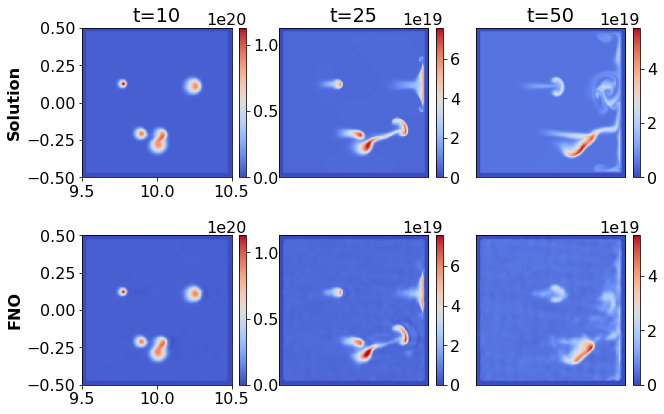

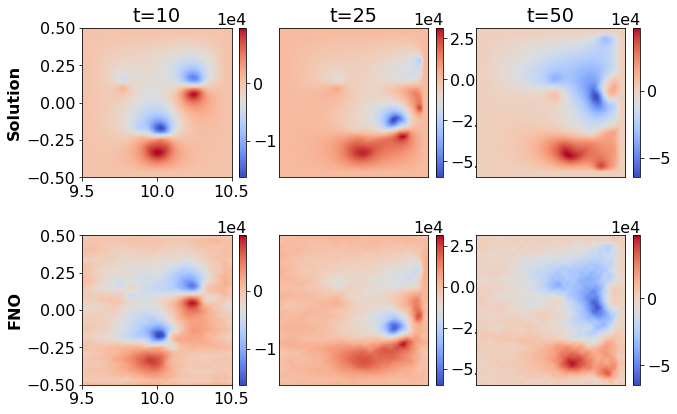

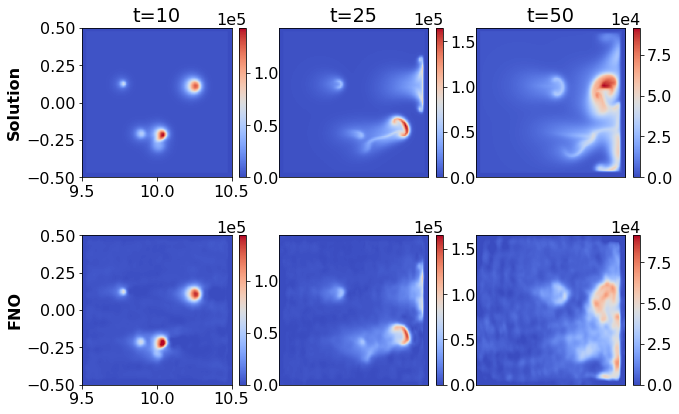

In [24]:
#Plotting the comparison plots
idx = np.random.randint(0,ntest) 
# idx = 5
# idx = 36
# idx = 3
# idx = 5  
idx = 15
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.rcParams['font.size']=16

output_plot = []
for dim in range(num_vars):
    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[dim,:,:,0])
    v_max_1 = torch.max(u_field[dim,:,:,0])

    v_min_2 = torch.min(u_field[dim, :, :, int(T/2)])
    v_max_2 = torch.max(u_field[dim, :, :, int(T/2)])

    v_min_3 = torch.min(u_field[dim, :, :, -1])
    v_max_3 = torch.max(u_field[dim, :, :, -1])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(2,3,1)
    pcm =ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    
    ax = fig.add_subplot(2,3,2)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,3)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = pred_set[idx]

    ax = fig.add_subplot(2,3,4)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,5)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,6)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

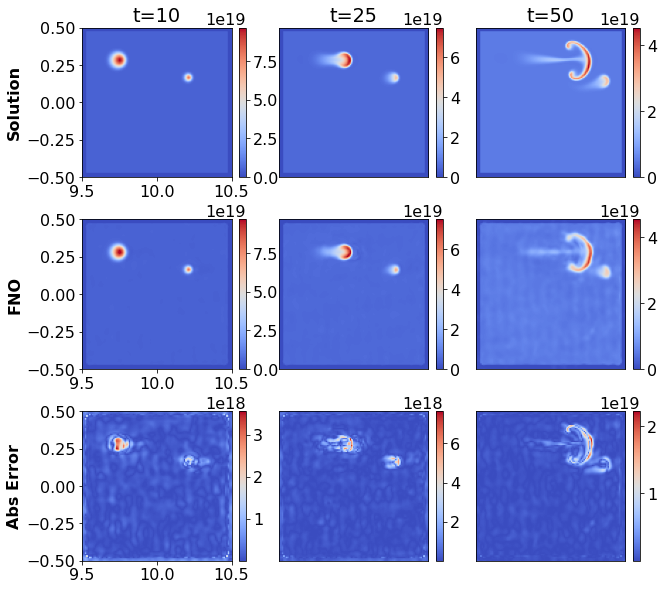

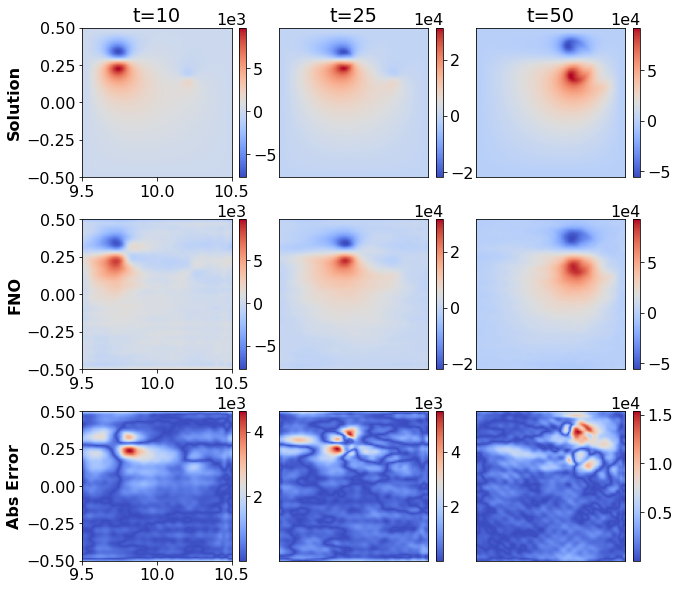

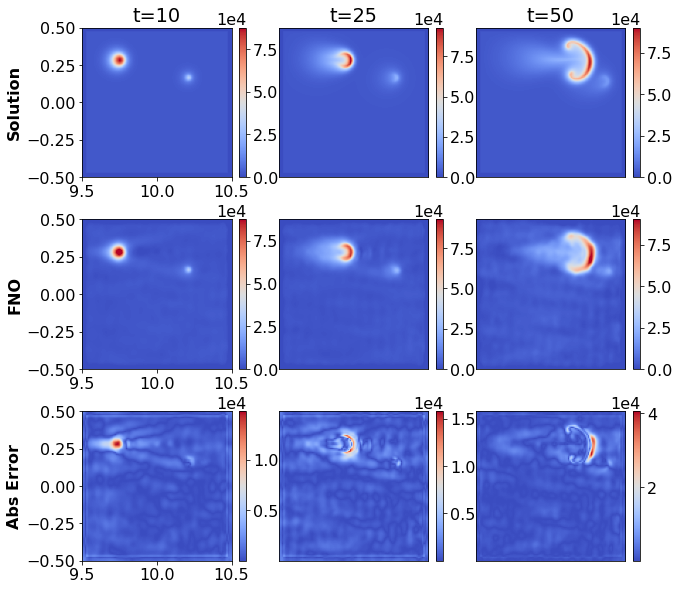

In [25]:
#Error Plots
idx = 8
output_plot = []
for dim in range(num_vars):
    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[dim,:,:,0])
    v_max_1 = torch.max(u_field[dim,:,:,0])

    v_min_2 = torch.min(u_field[dim, :, :, int(T/2)])
    v_max_2 = torch.max(u_field[dim, :, :, int(T/2)])

    v_min_3 = torch.min(u_field[dim, :, :, -1])
    v_max_3 = torch.max(u_field[dim, :, :, -1])

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(3,3,1)
    pcm =ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    
    ax = fig.add_subplot(3,3,2)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,3)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = pred_set[idx]

    ax = fig.add_subplot(3,3,4)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,5)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,6)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = torch.abs(test_u[idx] - pred_set[idx])

    ax = fig.add_subplot(3,3,7)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5])
    ax.set_ylabel('Abs Error', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,8)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,9)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    # plt.savefig("multiblobs_" + dims[dim] + "_" + str(idx) + "_reduced-fort.pdf", format="pdf", bbox_inches='tight', transparent='True')

In [26]:
import matplotlib as mpl
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '-'
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=45
mpl.rcParams['figure.figsize']=(16,16)
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 3
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
mpl.rcParams['axes.titlepad'] = 20

Text(0, 0.5, 'NMSE ')

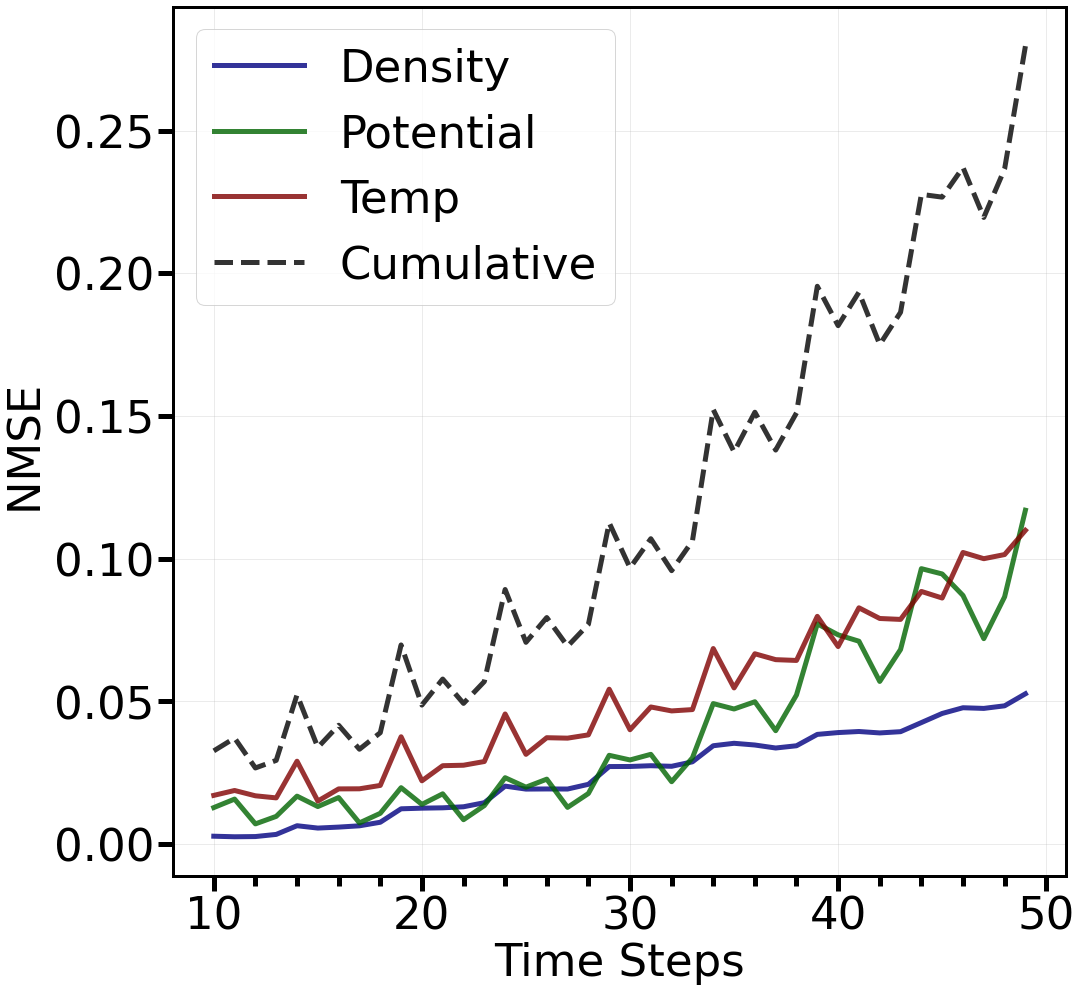

In [27]:
plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density', alpha=0.8,  color = 'navy', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential', alpha=0.8,  color = 'darkgreen', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp', alpha=0.8,  color = 'maroon', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), (err_rho+err_phi+err_T), label='Cumulative', alpha=0.8,  color = 'black', ls='--', linewidth=5)
plt.legend()
plt.grid()
plt.xlabel('Time Steps')
plt.ylabel('NMSE ')

# plt.savefig("multiblobs_error_growth_cum.pdf", bbox_inches='tight')
# plt.savefig("multiblobs_error_growth_cum.svg", bbox_inches='tight')

In [28]:
# #Dropout Plots
# #Cyan-Provolone
# configuration = {"Case": 'Multi-Blobs',
#                  "Field": 'rho, Phi, T',
#                  "Field_Mixing": 'Channel',
#                  "Type": '2D Time',
#                  "Epochs": 500,
#                  "Batch Size": 10,
#                  "Optimizer": 'Adam',
#                  "Learning Rate": 0.005,
#                  "Scheduler Step": 100,
#                  "Scheduler Gamma": 0.5,
#                  "Activation": 'GELU',
#                  "Normalisation Strategy": 'Min-Max',
#                  "Instance Norm": 'No',
#                  "Log Normalisation":  'No',
#                  "Physics Normalisation": 'Yes',
#                  "T_in": 10,    
#                  "T_out": 40,
#                  "Step": 5,
#                  "Modes":16,
#                  "Width_time":32, #FNO
#                  "Width_vars": 0, #U-Net
#                  "Variables":3, 
#                  "Noise":0.0, 
#                  "Loss Function": 'LP Loss',
#                  "Spatial Resolution": 1,
#                  "Temporal Resolution": 1,
#                  "UQ": 'Dropout',
#                  "Dropout Rate": 0.9
#                  }

# T_in  = configuration['T_in']
# T_out = configuration['T_out']
# step = configuration['Step']
# modes = configuration['Modes']
# width_vars = configuration['Width_vars']
# width_time = configuration['Width_time']


# class FNO_multi_dropout(nn.Module):
#     def __init__(self, modes1, modes2, width_vars, width_time):
#         super(FNO_multi_dropout, self).__init__()

#         """
#         The overall network. It contains 4 layers of the Fourier layer.
#         1. Lift the input to the desire channel dimension by self.fc0 .
#         2. 4 layers of the integral operators u' = (W + K)(u).
#             W defined by self.w; K defined by self.conv .
#         3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
#         input: the solution of the previous T_in timesteps + 2 locations (u(t-T_in, x, y), ..., u(t-1, x, y),  x, y)
#         input shape: (batchsize, x=x_discretistion, y=y_discretisation, c=T_in)
#         output: the solution of the next timestep
#         output shape: (batchsize, x=x_discretisation, y=y_discretisatiob, c=step)
#         """

#         self.modes1 = modes1
#         self.modes2 = modes2
#         self.width_vars = width_vars
#         self.width_time = width_time

#         self.fc0_time  = nn.Linear(T_in+2, self.width_time)

#         # self.padding = 8 # pad the domain if input is non-periodic

#         self.f0 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f1 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f2 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f3 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f4 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f5 = FNO2d(self.modes1, self.modes2, self.width_time)

#         self.dropout = nn.Dropout(p=0.1)

#         # self.norm = nn.InstanceNorm2d(self.width)
#         self.norm = nn.Identity()


#         self.fc1_time = nn.Linear(self.width_time, 128)
#         self.fc2_time = nn.Linear(128, step)


#     def forward(self, x):
#         grid = self.get_grid(x.shape, x.device)
#         x = torch.cat((x, grid), dim=-1)


#         x = self.fc0_time(x)
#         x = x.permute(0, 4, 1, 2, 3)
#         x = self.dropout(x)

#         # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

#         x0 = self.f0(x)
#         x = self.f1(x0)
#         x = self.f2(x) + x0 
#         x = self.dropout(x)
#         x1 = self.f3(x)
#         x = self.f4(x1)
#         x = self.f5(x) + x1 
#         x = self.dropout(x)

#         # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic

#         x = x.permute(0, 2, 3, 4, 1)
#         x = x 

#         x = self.fc1_time(x)
#         x = F.gelu(x)
#         x = self.dropout(x)
#         x = self.fc2_time(x)
        
#         return x

# #Using x and y values from the simulation discretisation 
#     def get_grid(self, shape, device):
#         batchsize, num_vars, size_x, size_y = shape[0], shape[1], shape[2], shape[3]
#         gridx = gridx = torch.tensor(x_grid, dtype=torch.float)
#         gridx = gridx.reshape(1, 1, size_x, 1, 1).repeat([batchsize, num_vars, 1, size_y, 1])
#         gridy = torch.tensor(y_grid, dtype=torch.float)
#         gridy = gridy.reshape(1, 1, 1, size_y, 1).repeat([batchsize, num_vars, size_x, 1, 1])
#         return torch.cat((gridx, gridy), dim=-1).to(device)

# ## Arbitrary grid discretisation 
#     # def get_grid(self, shape, device):
#     #     batchsize, size_x, size_y = shape[0], shape[1], shape[2]
#     #     gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
#     #     gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
#     #     gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
#     #     gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
#     #     return torch.cat((gridx, gridy), dim=-1).to(device)


#     def count_params(self):
#         c = 0
#         for p in self.parameters():
#             c += reduce(operator.mul, list(p.size()))

#         return c

# model = FNO_multi_dropout(modes, modes, width_vars, width_time)
# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_cyan-provolone.pth', map_location=torch.device('cpu')))
# model.to(device)



# # %%
# #Extracting the Mean and Variance across the time roll out to plot later. 

# # %%
# idx = 36
# model.eval()
# xx = test_a[idx:idx+1]
# yy = test_u_encoded[idx:idx+1,:, :,:,:10]
# var = 0 
# preds = []

# for i in tqdm(range(100)):
#         preds.append(model(xx).detach().numpy())

# preds_mean = np.mean(preds, axis=0)
# preds_std = np.std(preds, axis=0)
# # %%
# test_yy= y_normalizer.decode(torch.Tensor(yy)) * 1e20
# preds_mean = y_normalizer.decode(torch.Tensor(preds_mean)).detach().numpy() * 1e20
# preds_std= y_normalizer.decode(torch.Tensor(preds_std)).detach().numpy() * 1e20


# T = step

# u_field = test_yy[0][var]

# v_min_1 = torch.min(u_field[:,:,0])
# v_max_1 = torch.max(u_field[:,:,0])

# v_min_2 = torch.min(u_field[:, :, int(T/2)])
# v_max_2 = torch.max(u_field[:, :, int(T/2)])

# v_min_3 = torch.min(u_field[:, :, -1])
# v_max_3 = torch.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(2,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('Solution')
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# u_field = preds_mean[0][var]

# ax = fig.add_subplot(2,3,4)
# pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# ax.set_ylabel('FNO')

# fig.colorbar(pcm, pad=0.05)

# ax = fig.add_subplot(2,3,5)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,6)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)



# from mpl_toolkits.axes_grid1 import make_axes_locatable

# u_field = preds_std[0][var]

# v_min_1 = np.min(u_field[:,:,0])
# v_max_1 = np.max(u_field[:,:,0])

# v_min_2 = np.min(u_field[:, :, int(T/2)])
# v_max_2 = np.max(u_field[:, :, int(T/2)])

# v_min_3 = np.min(u_field[:, :, -1])
# v_max_3 = np.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.4))
# ax = fig.add_subplot(1,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('STD')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)

# # %%
# idx = 36
# model.eval()
# xx = test_a[idx:idx+1]
# yy = test_u_encoded[idx:idx+1]
# preds = []
# with torch.no_grad():
#     for i in tqdm(range(100)):
#         xx = test_a[idx:idx+1]
#         for t in range(0, T, step):
#             out = model(xx)

#             if t == 0:
#                 pred = out
#             else:
#                 pred = torch.cat((pred, out), -1)       

#             xx = torch.cat((xx[..., step:], out), dim=-1)
#         preds.append(pred.detach().numpy())



# # %%
# preds_mean = np.mean(preds, axis=0)
# preds_std = np.std(preds, axis=0)
# # %%
# test_yy = y_normalizer.decode(torch.Tensor(yy)) * 1e20
# preds_mean = y_normalizer.decode(torch.Tensor(preds_mean)).detach().numpy() * 1e20
# preds_std= y_normalizer.decode(torch.Tensor(preds_std)).detach().numpy() * 1e20

# # %%

# T = configuration['T_out']
# T = 5

# u_field = test_yy[0][var][...,:20]

# v_min_1 = torch.min(u_field[:,:,0])
# v_max_1 = torch.max(u_field[:,:,0])

# v_min_2 = torch.min(u_field[:, :, int(T/2)])
# v_max_2 = torch.max(u_field[:, :, int(T/2)])

# v_min_3 = torch.min(u_field[:, :, -1])
# v_max_3 = torch.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(2,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('Solution')
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# u_field = preds_mean[0][var]

# ax = fig.add_subplot(2,3,4)
# pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# ax.set_ylabel('FNO')

# fig.colorbar(pcm, pad=0.05)

# ax = fig.add_subplot(2,3,5)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,6)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)



# from mpl_toolkits.axes_grid1 import make_axes_locatable

# u_field = preds_std[0][var]

# v_min_1 = np.min(u_field[:,:,0])
# v_max_1 = np.max(u_field[:,:,0])

# v_min_2 = np.min(u_field[:, :, int(T/2)])
# v_max_2 = np.max(u_field[:, :, int(T/2)])

# v_min_3 = np.min(u_field[:, :, -1])
# v_max_3 = np.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.4))
# ax = fig.add_subplot(1,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('STD')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)

In [29]:
#Individual Models
configuration = {"Case": 'Multi-Blobs',
                 "Field": 'rho',
                 "Field_Mixing": 'Channel',
                 "Type": '2D Time',
                 "Epochs": 500,
                 "Batch Size": 4,
                 "Optimizer": 'Adam',
                 "Learning Rate": 0.001,
                 "Scheduler Step": 100,
                 "Scheduler Gamma": 0.5,
                 "Activation": 'GELU',
                 "Normalisation Strategy": 'Min-Max',
                 "Instance Norm": 'No',
                 "Log Normalisation": 'No',
                 "Physics Normalisation": 'Yes',
                 "T_in": 10,
                 "T_out": 40,
                 "Step":5,
                 "Modes": 16,
                 "Width_time": 32,  # FNO
                 "Width_vars": 0,  # U-Net
                 "Variables": 1,
                 "Noise": 0.0,
                 "Loss Function": 'LP Loss',
                 "Spatial Resolution": 1,
                 "Temporal Resolution": 1,
                 "Gradient Clipping Norm": None,
                 #  "UQ": 'Dropout',
                 #  "Dropout Rate": 0.9
                 }
dims = ['rho', 'Phi', 'T']

In [30]:
##################################
#Normalisation Functions 
##################################

# normalization, rangewise but single value.
#normalization, rangewise but across the full domain
class MinMax_Normalizer(object):
    def __init__(self, x, low=-1.0, high=1.0):
        super(MinMax_Normalizer, self).__init__()
        mymin = torch.min(x)
        mymax = torch.max(x)
        # mymin = torch.tensor(0.0)
        # mymax = torch.tensor(0.3)


        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

    def cuda(self):
        self.a = self.a.cuda()
        self.b = self.b.cuda()

    def cpu(self):
        self.a = self.a.cpu()
        self.b = self.b.cpu()

rho
preprocessing finished, time used: 1.2849699929356575
Number of model params : 3175461
(MSE) Testing Error: 3.712e-04
(MAE) Testing Error: 4.718e-03
(NMSE) Testing Error 2.956e-02
tensor(0.0118)
Phi
preprocessing finished, time used: 1.3873737069079652
Number of model params : 3175461
(MSE) Testing Error: 7.404e-03
(MAE) Testing Error: 8.546e-02
(NMSE) Testing Error 2.011e+00
tensor(0.0124)
T
preprocessing finished, time used: 1.3918594709830359
Number of model params : 3175461
(MSE) Testing Error: 8.790e-05
(MAE) Testing Error: 3.775e-03
(NMSE) Testing Error 4.788e-02
tensor(0.0002)


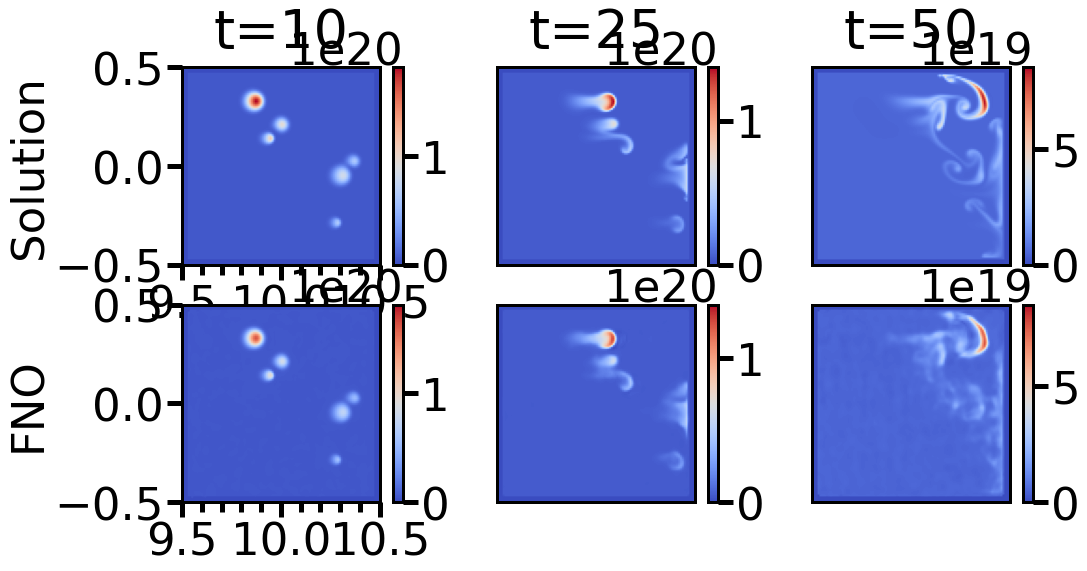

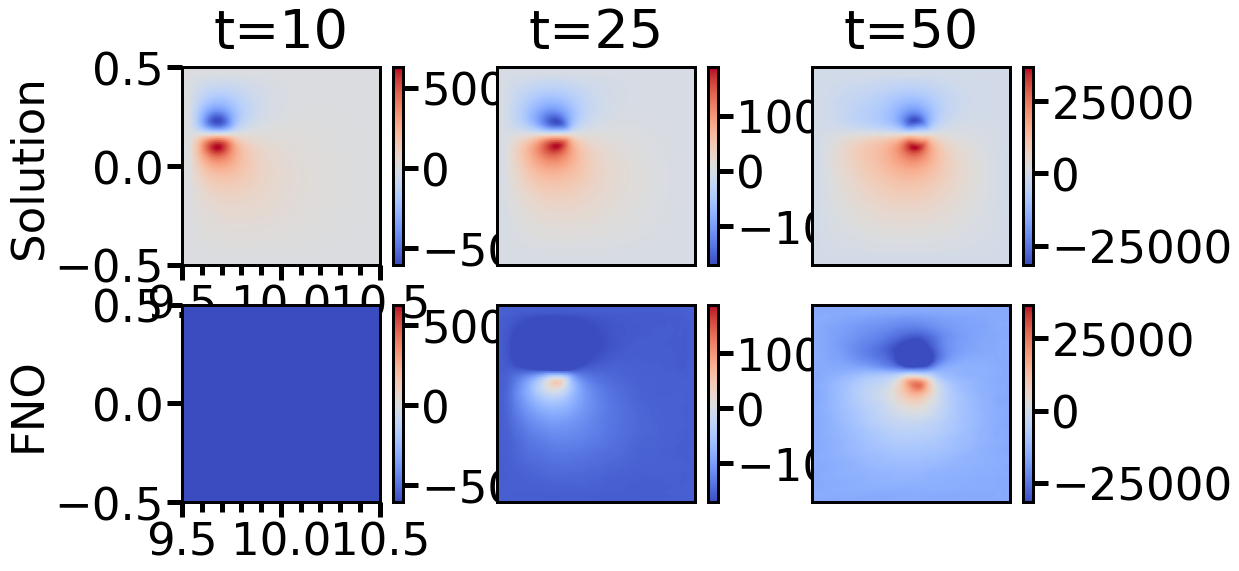

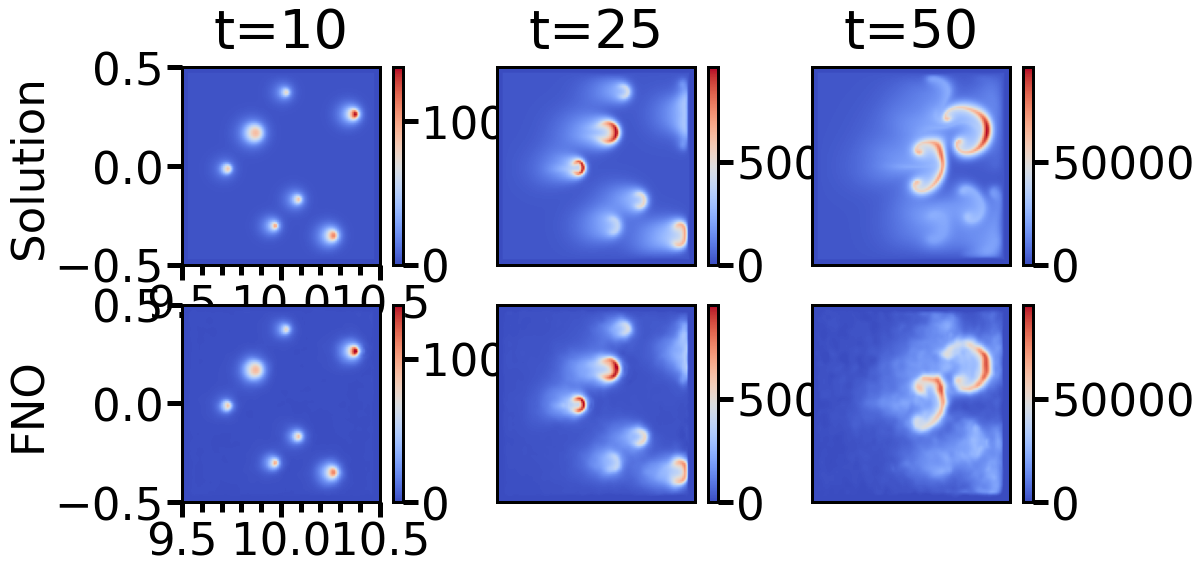

In [31]:
################################################################
# Preparing Data 
################################################################

errs = []
for field in dims:  
    print(field)
        
    if field == 'Phi':
        u_sol = np.load(data)['Phi'].astype(np.float32)   / 1e5
    elif field == 'T':
        u_sol = np.load(data)['T'].astype(np.float32)     / 1e6
    elif field == 'rho':
        u_sol = np.load(data)['rho'].astype(np.float32)   / 1e20

    if configuration['Log Normalisation'] == 'Yes':
        u_sol = np.log(u_sol)

    u_sol = np.nan_to_num(u_sol)
    # u_sol = np.delete(u_sol, (11, 160, 222, 273, 303, 357, 620, 797, 983, 1275, 1391, 1458, 1554, 1600, 1613, 1888, 1937, 1946, 1959), axis=0)
    u_sol= np.delete(u_sol, (153, 229), axis=0) #Outlier T values

    x_grid = np.load(data)['Rgrid'][0,:].astype(np.float32)
    y_grid = np.load(data)['Zgrid'][:,0].astype(np.float32)
    t_grid = np.load(data)['time'].astype(np.float32)

    ntrain = 240
    ntest = 36
    S =106  # Grid Size

    #Extracting hyperparameters from the config dict
    modes = configuration['Modes']

    output_size = configuration['Step']
    batch_size = configuration['Batch Size']
    T_in = configuration['T_in']
    T = configuration['T_out']
    step = configuration['Step']
    num_vars = configuration['Variables']
    width_time = configuration['Width_time']
    width_vars = configuration['Width_vars']
    t1 = default_timer()

    #At this stage the data needs to be [Batch_Size, X, Y, T]

    np.random.shuffle(u_sol)
    u = torch.from_numpy(u_sol)
    u = u.permute(0, 2, 3, 1)

    #At this stage the data needs to be [Batch_Size, X, Y, T]

    train_a = u[:ntrain,:,:,:T_in]
    train_u = u[:ntrain,:,:,T_in:T+T_in]

    test_a = u[-ntest:,:,:,:T_in]
    test_u = u[-ntest:,:,:,T_in:T+T_in]


    #Normalising the train and test datasets with the preferred normalisation. 
    norm_strategy = configuration['Normalisation Strategy']

    if norm_strategy == 'Min-Max':
        a_normalizer = MinMax_Normalizer(train_a)
        y_normalizer = MinMax_Normalizer(train_u)

    if norm_strategy == 'Range':
        a_normalizer = RangeNormalizer(train_a)
        y_normalizer = RangeNormalizer(train_u)

    if norm_strategy == 'Gaussian':
        a_normalizer = GaussianNormalizer(train_a)
        y_normalizer = GaussianNormalizer(train_u)


    test_a = a_normalizer.encode(test_a)
    test_u_encoded = y_normalizer.encode(test_u)


    t2 = default_timer()
    print('preprocessing finished, time used:', t2-t1)

    ################################################################
    # training and evaluation
    ################################################################

    #Instantiating the Model. 
    # model = FNO(modes, modes, width)
    num_vars = 1
    model = FNO_multi(T_in, step, num_vars, modes, modes, width_vars, width_time)

    if field == 'rho':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_fundamental-mesh.pth', map_location=torch.device('cpu')))
    if field == 'Phi':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_some-locker.pth', map_location=torch.device('cpu')))
    if field == 'T':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_covering-cube.pth', map_location=torch.device('cpu')))
    model.to(device)

    run.update_metadata({'Number of Params': int(model.count_params())})
    print("Number of model params : " + str(model.count_params()))

    if torch.cuda.is_available():
        y_normalizer.cuda()

    # Testing
    batch_size = 1
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a.unsqueeze(1), test_u_encoded.unsqueeze(1)), batch_size=1,
                                            shuffle=False)
    pred_set = torch.zeros(test_u.shape)
    index = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx, yy = xx.to(device), yy.to(device)
            # xx = additive_noise(xx)
            t1 = default_timer()
            for t in range(0, T, step):
                y = yy[..., t:t + step]
                out = model(xx)

                if t == 0:
                    pred = out
                else:
                    pred = torch.cat((pred, out), -1)

                xx = torch.cat((xx[..., step:], out), dim=-1)

            t2 = default_timer()
            # pred = y_normalizer.decode(pred)
            pred_set[index] = pred
            index += 1
            # print(t2 - t1)

    #Logging Metrics 
    MSE_error = (pred_set - test_u_encoded).pow(2).mean()
    MAE_error = torch.abs(pred_set - test_u_encoded).mean()
    # LP_error = loss / (ntest*T/step)
    # rel_error = torch.abs((pred_set - test_u_encoded)/test_u_encoded).mean() * 100 



    print('(MSE) Testing Error: %.3e' % (MSE_error))
    print('(MAE) Testing Error: %.3e' % (MAE_error))
    # print('(LP) Testing Error: %.3e' % (LP_error))
    # print('(MAPE) Testing Error %.3e' % (rel_error))
    # print('(NMSE) Testing Error %.3e' % (nmse))
    # print('(NRMSE) Testing Error %.3e' % (nrmse))

    # run.update_metadata({'MSE Test Error': float(MSE_error),
    #                     'MAE Test Error': float(MAE_error),
    #                     'LP Test Error': float(LP_error)
    #                     })

    pred_set_encoded = pred_set
    pred_set = y_normalizer.decode(pred_set.to(device)).cpu()
    pred_set_scaled = pred_set
    test_u_scaled = test_u

    nmse = ((pred_set_scaled - test_u_scaled).pow(2).mean() / test_u_scaled.pow(2).mean())
    print('(NMSE) Testing Error %.3e' % (nmse))



    if configuration["Physics Normalisation"] == 'Yes':
        if field == 'rho':
            pred_set = pred_set * 1e20
            test_u = test_u * 1e20
        if field == 'Phi':
            pred_set = pred_set * 1e5
            test_u = test_u * 1e5
        if field == 'T':
            pred_set= pred_set * 1e6
            test_u = test_u * 1e6

    #Plotting the comparison plots

    idx = np.random.randint(0,ntest) 
    # idx = 3
    idx = 15

    if configuration['Log Normalisation'] == 'Yes':
        test_u = torch.exp(test_u)
        pred_set = torch.exp(pred_set)

    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[:,:,0])
    v_max_1 = torch.max(u_field[:,:,0])

    v_min_2 = torch.min(u_field[:, :, int(T/2)])
    v_max_2 = torch.max(u_field[:, :, int(T/2)])

    v_min_3 = torch.min(u_field[:, :, -1])
    v_max_3 = torch.max(u_field[:, :, -1])

    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(2,3,1)
    pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution')
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,2)
    pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,3)
    pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    u_field = pred_set[idx]

    ax = fig.add_subplot(2,3,4)
    pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO')

    fig.colorbar(pcm, pad=0.05)

    ax = fig.add_subplot(2,3,5)
    pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,6)
    pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)

    #Plotting the error growth across time.
    err = [] 

    for ii in range(T):
        err.append((pred_set_scaled[...,ii] - test_u_scaled[...,ii]).pow(2).mean() / test_u_scaled.pow(2).mean())
    print(test_u_scaled.pow(2).mean())
    err = np.asarray(err)
    errs.append(err)

In [32]:
# plt.plot(np.arange(T_in, T_in + T), err, label=field + ' - solo', alpha=0.8,  color = 'tab:brown')
# plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density', alpha=0.8,  color = 'tab:blue')
# # plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential', alpha=0.8,  color = 'tab:orange')
# # plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp', alpha=0.8,  color = 'tab:green')
# # plt.plot(np.arange(T_in, T_in + T), (err_rho+err_phi+err_T), label='Cumulative', alpha=0.8,  color = 'tab:red', ls='--')
# plt.legend()
# plt.xlabel('Time Steps')
# plt.ylabel('NMAE ')

In [33]:
err_rho_solo, err_phi_solo, err_T_solo = errs[0], errs[1], errs[2]

Text(0, 0.5, 'NMSE ')

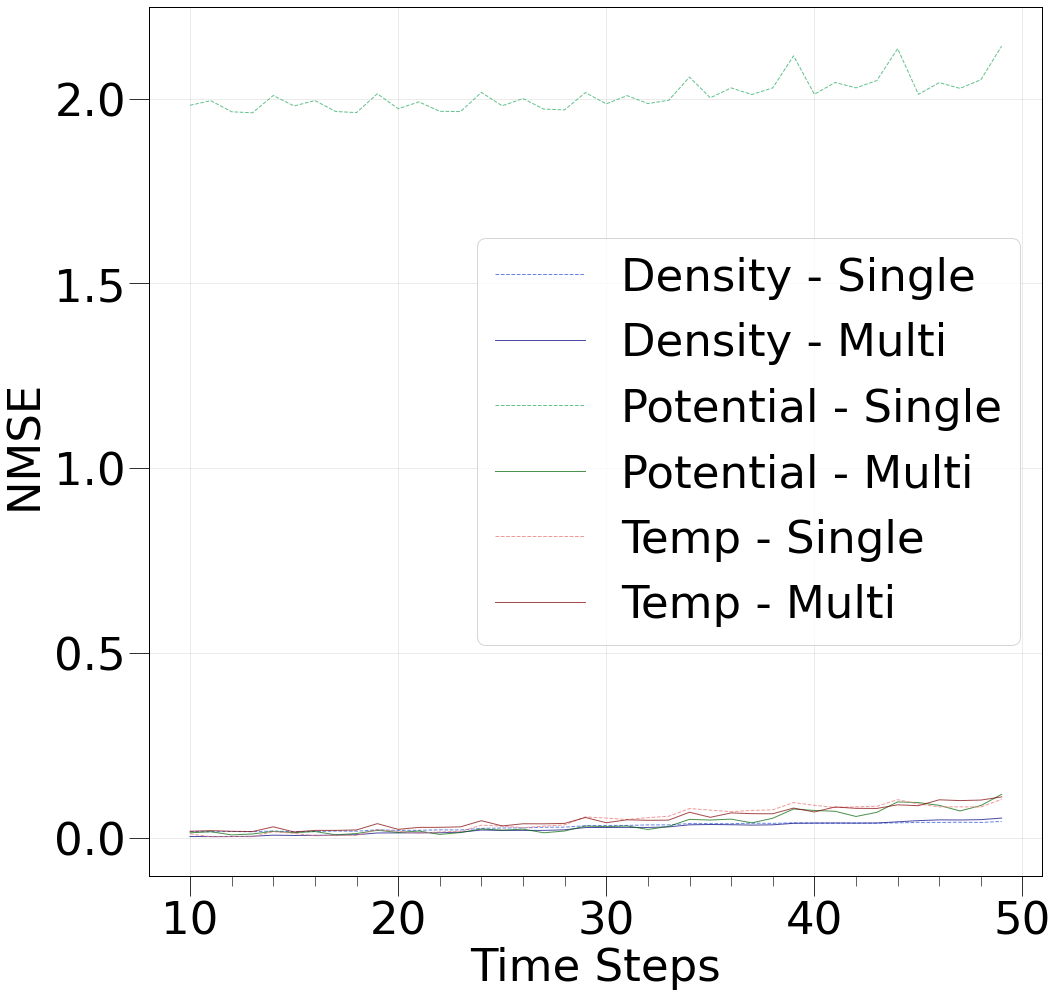

In [34]:
import matplotlib as mpl

plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '-'
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=45
mpl.rcParams['figure.figsize']=(16,16)
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 1
mpl.rcParams['axes.titlepad'] = 30
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['ytick.major.size'] = 20
plt.rcParams['xtick.minor.size'] = 10.0
plt.rcParams['ytick.minor.size'] = 10.0
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.minor.width'] = 0.6
mpl.rcParams['lines.linewidth'] = 1
plt.figure()
plt.grid()
plt.plot(np.arange(T_in, T_in + T), err_rho_solo, label='Density - Single', alpha=0.8,  color = 'royalblue', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density - Multi', alpha=0.7,  color = 'navy')
plt.plot(np.arange(T_in, T_in + T), err_phi_solo, label='Potential - Single', alpha=0.8,  color = 'mediumseagreen', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential - Multi', alpha=0.7,  color = 'darkgreen')
plt.plot(np.arange(T_in, T_in + T), err_T_solo, label='Temp - Single', alpha=0.8,  color = 'lightcoral', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp - Multi', alpha=0.7,  color = 'maroon')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('NMSE ')

# plt.savefig("multiblobs_error_growth.pdf", bbox_inches='tight')
# plt.savefig("multiblobs_error_growth.svg", bbox_inches='tight')

In [35]:
configuration = {"Case": 'Multi-Blobs',
                 "Field": 'rho, Phi, T',
                 "Field_Mixing": 'Channel',
                 "Type": '2D Time',
                 "Epochs": 0,
                 "Batch Size": 4,
                 "Optimizer": 'Adam',
                 "Learning Rate": 0.005,
                 "Scheduler Step": 100,
                 "Scheduler Gamma": 0.5,
                 "Activation": 'GELU',
                 "Normalisation Strategy": 'Min-Max. Single',
                 "Instance Norm": 'No',
                 "Log Normalisation":  'No',
                 "Physics Normalisation": 'Yes',
                 "T_in": 10,    
                 "T_out": 40,
                 "Step": 5,
                 "Modes": 16,
                 "Width_time":32, #FNO
                 "Width_vars": 0, #U-Net
                 "Variables":3, 
                 "Noise":0.0, 
                 "Loss Function": 'LP Loss',
                 "Spatial Resolution": 1,
                 "Temporal Resolution": 1,
                #  "UQ": 'Dropout',
                #  "Dropout Rate": 0.9
                 }

In [36]:
from simvue import Run
run = Run(mode='disabled')
run.init(folder="/FNO_MHD", tags=['FNO', 'MHD', 'JOREK', 'Multi-Blobs', 'MultiVariable'], metadata=configuration)

True

In [37]:
import os 
CODE = ['FNO_multiple.py']
# Save code files
for code_file in CODE:
    if os.path.isfile(code_file):
        run.save(code_file, 'code')
    elif os.path.isdir(code_file):
        run.save_directory(code_file, 'code', 'text/plain', preserve_path=True)
    else:
        print('ERROR: code file %s does not exist' % code_file)

In [38]:
import numpy as np
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import cm 

import operator
from functools import reduce
from functools import partial
from collections import OrderedDict

import time 
from timeit import default_timer
from tqdm import tqdm 

torch.manual_seed(0)
np.random.seed(0)

In [39]:
path = os.getcwd()
data_loc = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
# model_loc = os.path.dirname(os.path.dirname(os.getcwd()))
file_loc = os.getcwd()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
##################################
#Normalisation Functions 
##################################


# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=-1.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x


    def cuda(self):
        self.a = self.a.cuda()
        self.b = self.b.cuda()

    def cpu(self):
        self.a = self.a.cpu()
        self.b = self.b.cpu()

# #normalization, rangewise but single value. 


# normalization, rangewise but single value.
class MinMax_Normalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(MinMax_Normalizer, self).__init__()
        min_u = torch.min(x[:, 0, :, :, :])
        max_u = torch.max(x[:, 0, :, :, :])

        self.a_u = (high - low) / (max_u - min_u)
        self.b_u = -self.a_u * max_u + high

        min_v = torch.min(x[:, 1, :, :, :])
        max_v = torch.max(x[:, 1, :, :, :])

        self.a_v = (high - low) / (max_v - min_v)
        self.b_v = -self.a_v * max_v + high

        min_p = torch.min(x[:, 2, :, :, :])
        max_p = torch.max(x[:, 2, :, :, :])

        self.a_p = (high - low) / (max_p - min_p)
        self.b_p = -self.a_p * max_p + high

    def encode(self, x):
        s = x.size()

        u = x[:, 0, :, :, :]
        u = self.a_u * u + self.b_u

        v = x[:, 1, :, :, :]
        v = self.a_v * v + self.b_v

        p = x[:, 2, :, :, :]
        p = self.a_p * p + self.b_p

        x = torch.stack((u, v, p), dim=1)

        return x

    def decode(self, x):
        s = x.size()

        u = x[:, 0, :, :, :]
        u = (u - self.b_u) / self.a_u

        v = x[:, 1, :, :, :]
        v = (v - self.b_v) / self.a_v

        p = x[:, 2, :, :, :]
        p = (p - self.b_p) / self.a_p

        x = torch.stack((u, v, p), dim=1)

        return x

    def cuda(self):
        self.a_u = self.a_u.cuda()
        self.b_u = self.b_u.cuda()

        self.a_v = self.a_v.cuda()
        self.b_v = self.b_v.cuda()

        self.a_p = self.a_p.cuda()
        self.b_p = self.b_p.cuda()

    def cpu(self):
        self.a_u = self.a_u.cpu()
        self.b_u = self.b_u.cpu()

        self.a_v = self.a_v.cpu()
        self.b_v = self.b_v.cpu()

        self.a_p = self.a_p.cpu()
        self.b_p = self.b_p.cpu()


        

# #normalization, rangewise but across the full domain 
# class MinMax_Normalizer(object):
#     def __init__(self, x, low=-1.0, high=1.0):
#         super(MinMax_Normalizer, self).__init__()
#         mymin = torch.min(x)
#         mymax = torch.max(x)

#         self.a = (high - low)/(mymax - mymin)
#         self.b = -self.a*mymax + high

#     def encode(self, x):
#         s = x.size()
#         x = x.reshape(s[0], -1)
#         x = self.a*x + self.b
#         x = x.view(s)
#         return x

#     def decode(self, x):
#         s = x.size()
#         x = x.reshape(s[0], -1)
#         x = (x - self.b)/self.a
#         x = x.view(s)
#         return x

#     def cuda(self):
#         self.a = self.a.cuda()
#         self.b = self.b.cuda()

#     def cpu(self):
#         self.a = self.a.cpu()
#         self.b = self.b.cpu()

In [41]:
##################################
# Loss Functions
##################################

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [42]:
x_grid = np.arange(0, 106)
y_grid = np.arange(0, 106)
S = 106 #Grid Size
size_x = S
size_y = S


modes = configuration['Modes']
width_time = configuration['Width_time']
width_vars = configuration['Width_vars']
output_size = configuration['Step']

batch_size = configuration['Batch Size']

batch_size2 = batch_size

t1 = default_timer()

T_in = configuration['T_in']
T = configuration['T_out']
step = configuration['Step']
num_vars = configuration['Variables']

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, num_vars):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.num_vars = num_vars

        self.scale = (1 / (in_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, num_vars, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, num_vars, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bivxy,iovxy->bovxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, self.num_vars, x.size(-2), x.size(-1) // 2 + 1,
                             dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv3d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv3d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, num_vars):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.num_vars = num_vars

        self.conv = SpectralConv2d(self.width, self.width, self.modes1, self.modes2, self.num_vars)
        self.mlp = MLP(self.width, self.width, self.width)
        self.w = nn.Conv3d(self.width, self.width, 1)
        self.b = nn.Conv3d(2, self.width, 1)

    def forward(self, x, grid):
        x1 = self.conv(x)
        x1 = self.mlp(x1)
        x2 = self.w(x)
        x3 = self.b(grid)
        x = x1 + x2 + x3
        x = F.gelu(x)
        return x

In [45]:
class FNO_multi(nn.Module):
    def __init__(self,T_in, step, num_vars, modes1, modes2, width_vars, width_time):
        super(FNO_multi, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous T_in timesteps + 2 locations (u(t-T_in, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=x_discretistion, y=y_discretisation, c=T_in)
        output: the solution of the next timestep
        output shape: (batchsize, x=x_discretisation, y=y_discretisatiob, c=step)
        """
        self.T_in = T_in
        self.step = step 
        self.num_vars = num_vars
        self.modes1 = modes1
        self.modes2 = modes2
        self.width_vars = width_vars
        self.width_time = width_time

        self.fc0_time = nn.Linear(self.T_in + 2, self.width_time)

        # self.padding = 8 # pad the domain if input is non-periodic

        self.f0 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f1 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f2 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f3 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f4 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f5 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)

        # self.norm = nn.InstanceNorm2d(self.width)
        self.norm = nn.Identity()

        self.fc1_time = nn.Linear(self.width_time, 256)
        self.fc2_time = nn.Linear(256, self.step)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)

        x = self.fc0_time(x)
        x = x.permute(0, 4, 1, 2, 3)
        grid = grid.permute(0, 4, 1, 2, 3)
        # x = self.dropout(x)

        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x0 = self.f0(x, grid)
        x = self.f1(x0, grid)
        x = self.f2(x, grid) + x0
        x1 = self.f3(x, grid)
        x = self.f4(x1, grid)
        x = self.f5(x, grid) + x1

        # x = self.dropout(x)

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic

        x = x.permute(0, 2, 3, 4, 1)
        x = x

        x = self.fc1_time(x)
        x = F.gelu(x)
        # x = self.dropout(x)
        x = self.fc2_time(x)

        return x

    # Using x and y values from the simulation discretisation
    def get_grid(self, shape, device):
        batchsize, num_vars, size_x, size_y = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(9.5, 10.5, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1, 1).repeat([batchsize, num_vars, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(-0.5, 0.5, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y, 1).repeat([batchsize, num_vars, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

    ## Arbitrary grid discretisation
    # def get_grid(self, shape, device):
    #     batchsize, size_x, size_y = shape[0], shape[1], shape[2]
    #     gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    #     gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
    #     gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
    #     gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
    #     return torch.cat((gridx, gridy), dim=-1).to(device)

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [46]:
################################################################
# Loading Data 
################################################################

In [47]:
data = data_loc + '/Data/MHD_multi_blobs.npz'
# data = data_loc + '/Data/FNO_MHD_data_multi_blob_2000_T50.npz'# new dataset

In [48]:
field = configuration['Field']
dims = ['rho', 'Phi', 'T']
num_vars = configuration['Variables']

u_sol = np.load(data)['rho'].astype(np.float32)  / 1e20
v_sol = np.load(data)['Phi'].astype(np.float32)  / 1e5
p_sol = np.load(data)['T'].astype(np.float32)    / 1e6

u_sol = np.nan_to_num(u_sol)
v_sol = np.nan_to_num(v_sol)
p_sol = np.nan_to_num(p_sol)

u = torch.from_numpy(u_sol)
u = u.permute(0, 2, 3, 1)

v = torch.from_numpy(v_sol)
v = v.permute(0, 2, 3, 1)

p = torch.from_numpy(p_sol)
p = p.permute(0, 2, 3, 1)

t_res = configuration['Temporal Resolution']
x_res = configuration['Spatial Resolution']
uvp = torch.stack((u,v,p), dim=1)[:,::t_res]
uvp = np.delete(uvp, (153, 229), axis=0)  # Outlier T values
# uvp = np.delete(uvp, (11, 160, 222, 273, 303, 357, 620, 797, 983, 1275, 1391, 1458, 1554, 1600, 1613, 1888, 1937, 1946, 1959), axis=0) #Only for the new dataset 
    
np.random.shuffle(uvp)

x_grid = np.load(data)['Rgrid'][0,:].astype(np.float32)
y_grid = np.load(data)['Zgrid'][:,0].astype(np.float32)
t_grid = np.load(data)['time'].astype(np.float32)

ntrain =240
ntest = 36

# ntrain = 1500 #new dataset
# ntest = 85 #new dataset

S = 106 #Grid Size
size_x = S
size_y = S

batch_size = configuration['Batch Size']

batch_size2 = batch_size

t1 = default_timer()



train_a = uvp[:ntrain,:,:,:,:T_in]
train_u = uvp[:ntrain,:,:,:,T_in:T+T_in]

test_a = uvp[-ntest:,:,:,:,:T_in]
test_u = uvp[-ntest:,:,:,:,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)

torch.Size([240, 3, 106, 106, 40])
torch.Size([36, 3, 106, 106, 40])


/home/ir-gopa2/rds/rds-ukaea-ap001/ir-gopa2/Code/Fourier_NNs/Multi_Blobs/Plots_zl.py:29: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  "Modes": 16,


In [49]:
# a_normalizer = RangeNormalizer(train_a)
a_normalizer = MinMax_Normalizer(train_a)
# a_normalizer = GaussianNormalizer(train_a)

train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

# y_normalizer = RangeNormalizer(train_u)
y_normalizer = MinMax_Normalizer(train_u)
# y_normalizer = GaussianNormalizer(train_u)

train_u = y_normalizer.encode(train_u)
test_u_encoded = y_normalizer.encode(test_u)

In [50]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u_encoded), batch_size=batch_size, shuffle=False)

t2 = default_timer()
print('preprocessing finished, time used:', t2-t1)

preprocessing finished, time used: 4.43769027502276


In [51]:
################################################################
# training and evaluation
################################################################

# model = FNO_multi(16, 16, width_vars, width_time)
model = FNO_multi(T_in, step, num_vars, modes, modes, width_vars, width_time)

# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_weary-tactics.pth', map_location=torch.device('cpu'))) #Min-Max Diff
# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_polite-comment.pth', map_location=torch.device('cpu'))) #Min-Max Same 
model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_dynamic-duck.pth', map_location=torch.device('cpu'))) #Min-Max Diff

model.to(device)

run.update_metadata({'Number of Params': int(model.count_params())})
print("Number of model params : " + str(model.count_params()))

Number of model params : 9466917


In [52]:
epochs = configuration['Epochs']
if torch.cuda.is_available():
    y_normalizer.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=configuration['Learning Rate'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=configuration['Scheduler Step'], gamma=configuration['Scheduler Gamma'])

myloss = LpLoss(size_average=False)

In [53]:
epochs = configuration['Epochs']
if torch.cuda.is_available():
    y_normalizer.cuda()

In [54]:
#Testing 
batch_size = 1
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u_encoded), batch_size=1, shuffle=False)
pred_set = torch.zeros(test_u.shape)
index = 0
with torch.no_grad():
    for xx, yy in tqdm(test_loader):
        loss = 0
        xx, yy = xx.to(device), yy.to(device)
        # xx = additive_noise(xx)
        t1 = default_timer()
        for t in range(0, T, step):
            y = yy[..., t:t + step]
            out = model(xx)
            loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = out
            else:
                pred = torch.cat((pred, out), -1)       

            xx = torch.cat((xx[..., step:], out), dim=-1)

        t2 = default_timer()
        # pred = y_normalizer.decode(pred)
        pred_set[index]=pred
        index += 1
        print(t2-t1)

  3%|▎         | 1/36 [00:02<01:18,  2.24s/it]

2.238433543010615


  6%|▌         | 2/36 [00:04<01:16,  2.26s/it]

2.2712695610243827


  8%|▊         | 3/36 [00:06<01:15,  2.30s/it]

2.334549475926906


 11%|█         | 4/36 [00:09<01:13,  2.30s/it]

2.2920739400433376


 14%|█▍        | 5/36 [00:11<01:10,  2.27s/it]

2.2224885169416666


 17%|█▋        | 6/36 [00:13<01:07,  2.25s/it]

2.1969041569391266


 19%|█▉        | 7/36 [00:15<01:05,  2.26s/it]

2.2713047800352797


 22%|██▏       | 8/36 [00:18<01:03,  2.25s/it]

2.245611371938139


 25%|██▌       | 9/36 [00:20<01:00,  2.25s/it]

2.2396151879802346


 28%|██▊       | 10/36 [00:22<00:58,  2.24s/it]

2.197326711961068


 31%|███       | 11/36 [00:24<00:55,  2.21s/it]

2.149820182006806


 33%|███▎      | 12/36 [00:26<00:53,  2.22s/it]

2.2392500130226836


 36%|███▌      | 13/36 [00:29<00:50,  2.21s/it]

2.1647338999900967


 39%|███▉      | 14/36 [00:31<00:48,  2.21s/it]

2.2071449169889092


 42%|████▏     | 15/36 [00:33<00:46,  2.21s/it]

2.214847820927389


 44%|████▍     | 16/36 [00:35<00:43,  2.20s/it]

2.1616970549803227


 47%|████▋     | 17/36 [00:37<00:41,  2.20s/it]

2.1867884639650583


 50%|█████     | 18/36 [00:40<00:39,  2.19s/it]

2.15781019104179


 53%|█████▎    | 19/36 [00:42<00:36,  2.17s/it]

2.1322094540810212


 56%|█████▌    | 20/36 [00:44<00:34,  2.17s/it]

2.1605525870108977


 58%|█████▊    | 21/36 [00:46<00:32,  2.17s/it]

2.157865344081074


 61%|██████    | 22/36 [00:48<00:30,  2.15s/it]

2.120607107062824


 64%|██████▍   | 23/36 [00:50<00:27,  2.15s/it]

2.141379341017455


 67%|██████▋   | 24/36 [00:52<00:25,  2.16s/it]

2.163429524982348


 69%|██████▉   | 25/36 [00:55<00:23,  2.16s/it]

2.160680219065398


 72%|███████▏  | 26/36 [00:57<00:21,  2.16s/it]

2.1553077989956364


 75%|███████▌  | 27/36 [00:59<00:19,  2.17s/it]

2.208704955992289


 78%|███████▊  | 28/36 [01:01<00:17,  2.18s/it]

2.181969363009557


 81%|████████  | 29/36 [01:03<00:15,  2.18s/it]

2.1812065980629995


 83%|████████▎ | 30/36 [01:06<00:13,  2.18s/it]

2.1864711981033906


 86%|████████▌ | 31/36 [01:08<00:10,  2.19s/it]

2.213280012947507


 89%|████████▉ | 32/36 [01:11<00:09,  2.36s/it]

2.7514691109536216


 92%|█████████▏| 33/36 [01:13<00:06,  2.30s/it]

2.161947411019355


 94%|█████████▍| 34/36 [01:15<00:04,  2.26s/it]

2.140331409056671


 97%|█████████▋| 35/36 [01:17<00:02,  2.23s/it]

2.1496408729581162


100%|██████████| 36/36 [01:19<00:00,  2.22s/it]

2.2942823889898136


In [55]:
print(pred_set.shape, test_u.shape)
#Logging Metrics 
MSE_error = (pred_set - test_u_encoded).pow(2).mean()
MAE_error = torch.abs(pred_set - test_u_encoded).mean()
LP_error = loss / (ntest*T/step)
rel_error = torch.abs((pred_set - test_u_encoded)/test_u_encoded).mean() * 100 
nmse = ((pred_set - test_u_encoded).pow(2).mean() / test_u_encoded.pow(2).mean())
nrmse = torch.sqrt((pred_set - test_u_encoded).pow(2).mean()) / torch.std(test_u_encoded)

print('(MSE) Testing Error: %.3e' % (MSE_error))
print('(MAE) Testing Error: %.3e' % (MAE_error))
# print('(LP) Testing Error: %.3e' % (LP_error))
# print('(MAPE) Testing Error %.3e' % (rel_error))
# print('(NMSE) Testing Error %.3e' % (nmse))
# print('(NRMSE) Testing Error %.3e' % (nrmse))

# run.update_metadata({'MSE Test Error': float(MSE_error),
#                      'MAE Test Error': float(MAE_error),
#                      'LP Test Error': float(LP_error)
#                     })


pred_set_encoded = pred_set
pred_set = y_normalizer.decode(pred_set.to(device)).cpu()

nmse= 0 
for ii in range(num_vars):
    nmse += (pred_set[:,ii] - test_u[:,ii]).pow(2).mean() / test_u[:,ii].pow(2).mean()
    print(test_u[:,ii].pow(2).mean())
nmse = nmse/num_vars
print('(NMSE) Testing Error %.3e' % (nmse))

pred_set_scaled = pred_set
test_u_scaled = test_u

torch.Size([36, 3, 106, 106, 40]) torch.Size([36, 3, 106, 106, 40])
(MSE) Testing Error: 4.668e-05
(MAE) Testing Error: 3.332e-03
tensor(0.0116)
tensor(0.0115)
tensor(0.0002)
(NMSE) Testing Error 3.835e-02


In [56]:
#Plotting the error growth across time.
err_rho = [] 
err_phi = []
err_T = []

for ii in range(T):
    err_rho.append((pred_set_scaled[:,0,:,:,ii] - test_u_scaled[:,0,:,:,ii]).pow(2).mean() / test_u_scaled[:,0].pow(2).mean())
    err_phi.append((pred_set_scaled[:,1,:,:,ii] - test_u_scaled[:,1,:,:,ii]).pow(2).mean() / test_u_scaled[:,1].pow(2).mean())
    err_T.append((pred_set_scaled[:,2,:,:,ii] - test_u_scaled[:,2,:,:,ii]).pow(2).mean() / test_u_scaled[:,2].pow(2).mean())

err_rho = np.asarray(err_rho)
err_phi = np.asarray(err_phi)
err_T = np.asarray(err_T)

In [57]:
if configuration["Physics Normalisation"] == 'Yes':
    pred_set[:,0:1,...] = pred_set[:,0:1,...] * 1e20
    pred_set[:,1:2,...] = pred_set[:,1:2,...] * 1e5
    pred_set[:,2:3,...] = pred_set[:,2:3,...] * 1e6


    test_u[:,0:1,...] = test_u[:,0:1,...] * 1e20
    test_u[:,1:2,...] = test_u[:,1:2,...] * 1e5
    test_u[:,2:3,...] = test_u[:,2:3,...] * 1e6

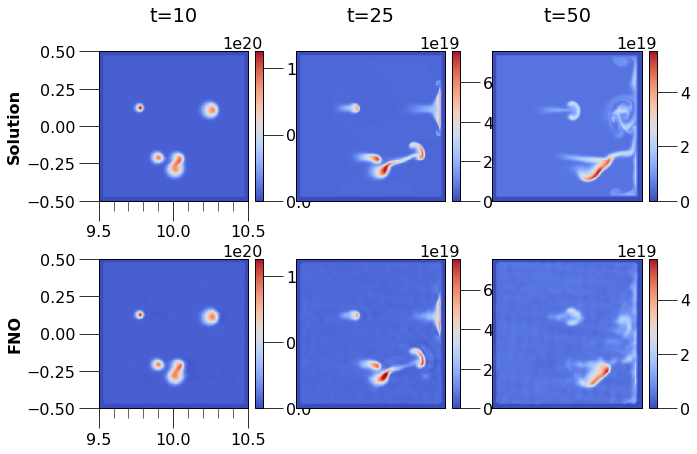

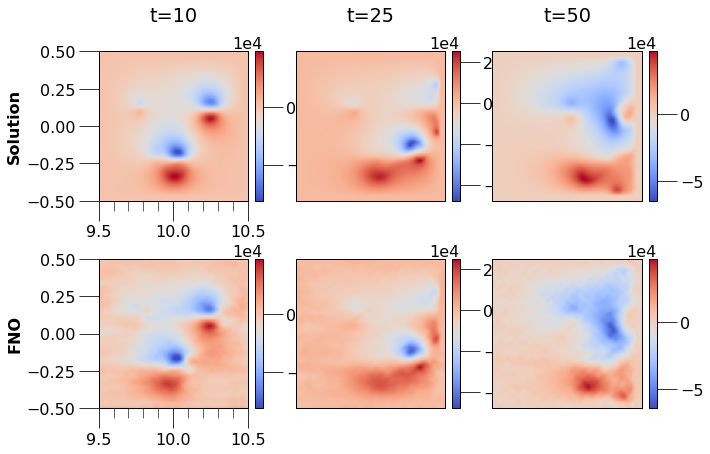

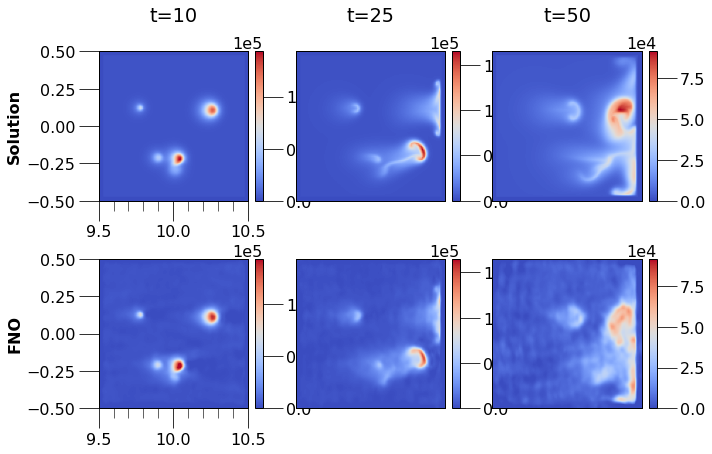

In [58]:
#Plotting the comparison plots
idx = np.random.randint(0,ntest) 
# idx = 5
# idx = 36
# idx = 3
# idx = 5  
idx = 15
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.rcParams['font.size']=16

output_plot = []
for dim in range(num_vars):
    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[dim,:,:,0])
    v_max_1 = torch.max(u_field[dim,:,:,0])

    v_min_2 = torch.min(u_field[dim, :, :, int(T/2)])
    v_max_2 = torch.max(u_field[dim, :, :, int(T/2)])

    v_min_3 = torch.min(u_field[dim, :, :, -1])
    v_max_3 = torch.max(u_field[dim, :, :, -1])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(2,3,1)
    pcm =ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    
    ax = fig.add_subplot(2,3,2)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,3)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = pred_set[idx]

    ax = fig.add_subplot(2,3,4)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,5)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,6)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

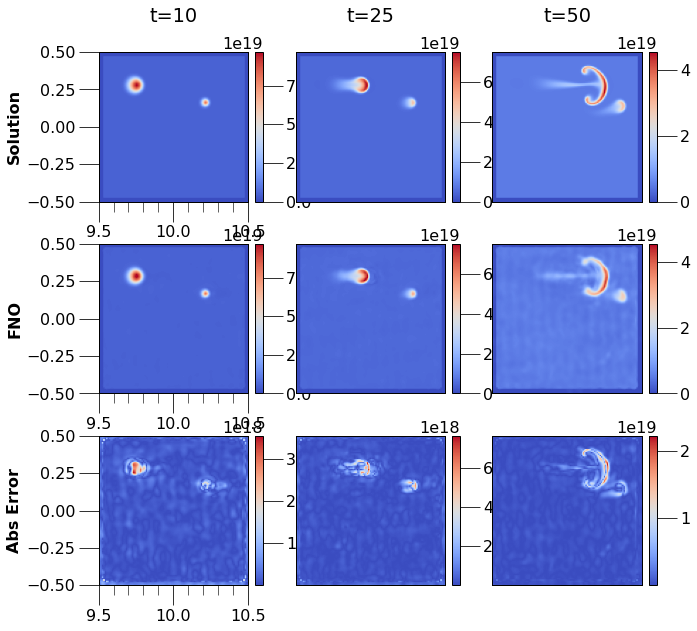

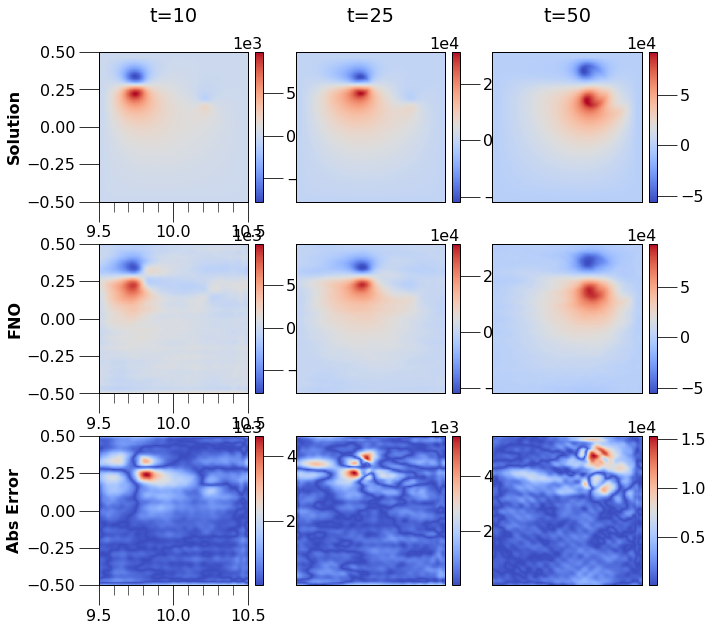

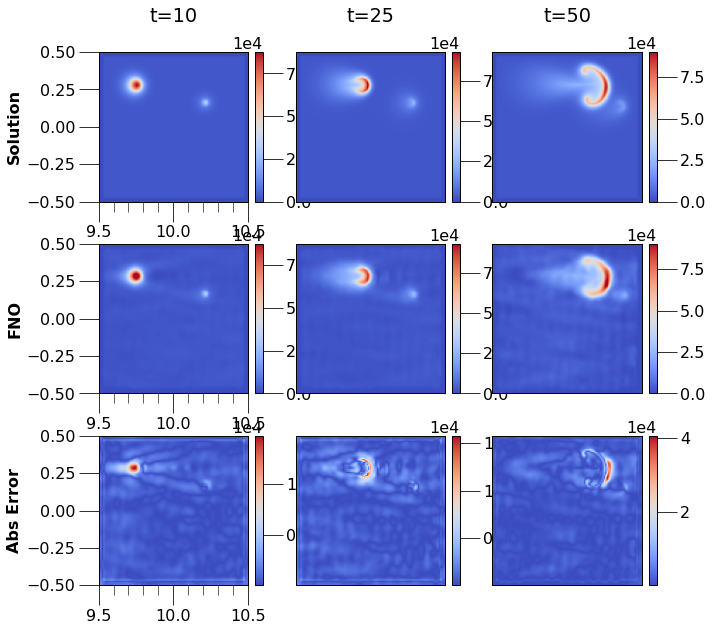

In [59]:
#Error Plots
idx = 8
output_plot = []
for dim in range(num_vars):
    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[dim,:,:,0])
    v_max_1 = torch.max(u_field[dim,:,:,0])

    v_min_2 = torch.min(u_field[dim, :, :, int(T/2)])
    v_max_2 = torch.max(u_field[dim, :, :, int(T/2)])

    v_min_3 = torch.min(u_field[dim, :, :, -1])
    v_max_3 = torch.max(u_field[dim, :, :, -1])

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(3,3,1)
    pcm =ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    
    ax = fig.add_subplot(3,3,2)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,3)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = pred_set[idx]

    ax = fig.add_subplot(3,3,4)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,5)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,6)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = torch.abs(test_u[idx] - pred_set[idx])

    ax = fig.add_subplot(3,3,7)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5])
    ax.set_ylabel('Abs Error', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,8)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,9)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    # plt.savefig("multiblobs_" + dims[dim] + "_" + str(idx) + "_reduced-fort.pdf", format="pdf", bbox_inches='tight', transparent='True')

In [60]:
import matplotlib as mpl
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '-'
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=45
mpl.rcParams['figure.figsize']=(16,16)
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 3
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
mpl.rcParams['axes.titlepad'] = 20

Text(0, 0.5, 'NMSE ')

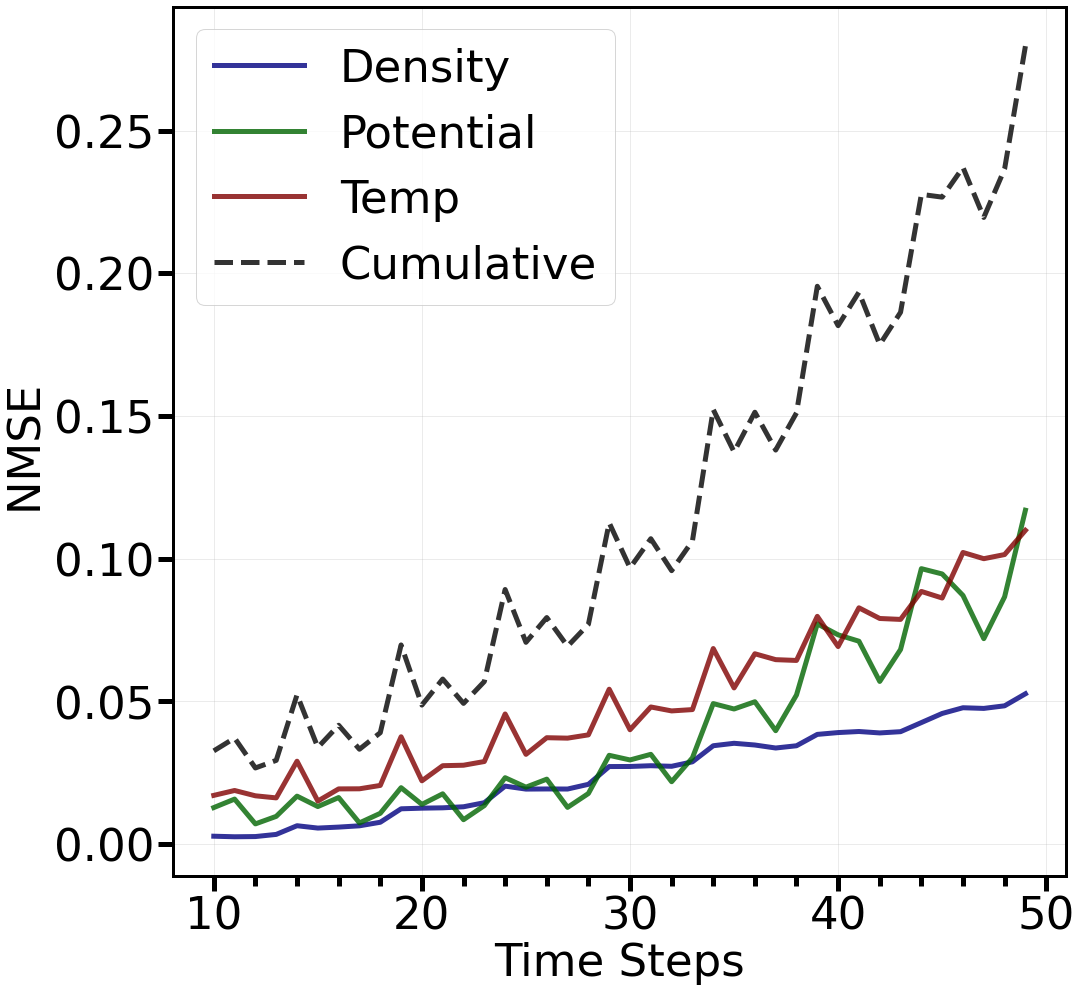

In [61]:
plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density', alpha=0.8,  color = 'navy', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential', alpha=0.8,  color = 'darkgreen', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp', alpha=0.8,  color = 'maroon', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), (err_rho+err_phi+err_T), label='Cumulative', alpha=0.8,  color = 'black', ls='--', linewidth=5)
plt.legend()
plt.grid()
plt.xlabel('Time Steps')
plt.ylabel('NMSE ')

# plt.savefig("multiblobs_error_growth_cum.pdf", bbox_inches='tight')
# plt.savefig("multiblobs_error_growth_cum.svg", bbox_inches='tight')

In [62]:
# #Dropout Plots
# #Cyan-Provolone
# configuration = {"Case": 'Multi-Blobs',
#                  "Field": 'rho, Phi, T',
#                  "Field_Mixing": 'Channel',
#                  "Type": '2D Time',
#                  "Epochs": 500,
#                  "Batch Size": 10,
#                  "Optimizer": 'Adam',
#                  "Learning Rate": 0.005,
#                  "Scheduler Step": 100,
#                  "Scheduler Gamma": 0.5,
#                  "Activation": 'GELU',
#                  "Normalisation Strategy": 'Min-Max',
#                  "Instance Norm": 'No',
#                  "Log Normalisation":  'No',
#                  "Physics Normalisation": 'Yes',
#                  "T_in": 10,    
#                  "T_out": 40,
#                  "Step": 5,
#                  "Modes":16,
#                  "Width_time":32, #FNO
#                  "Width_vars": 0, #U-Net
#                  "Variables":3, 
#                  "Noise":0.0, 
#                  "Loss Function": 'LP Loss',
#                  "Spatial Resolution": 1,
#                  "Temporal Resolution": 1,
#                  "UQ": 'Dropout',
#                  "Dropout Rate": 0.9
#                  }

# T_in  = configuration['T_in']
# T_out = configuration['T_out']
# step = configuration['Step']
# modes = configuration['Modes']
# width_vars = configuration['Width_vars']
# width_time = configuration['Width_time']


# class FNO_multi_dropout(nn.Module):
#     def __init__(self, modes1, modes2, width_vars, width_time):
#         super(FNO_multi_dropout, self).__init__()

#         """
#         The overall network. It contains 4 layers of the Fourier layer.
#         1. Lift the input to the desire channel dimension by self.fc0 .
#         2. 4 layers of the integral operators u' = (W + K)(u).
#             W defined by self.w; K defined by self.conv .
#         3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
#         input: the solution of the previous T_in timesteps + 2 locations (u(t-T_in, x, y), ..., u(t-1, x, y),  x, y)
#         input shape: (batchsize, x=x_discretistion, y=y_discretisation, c=T_in)
#         output: the solution of the next timestep
#         output shape: (batchsize, x=x_discretisation, y=y_discretisatiob, c=step)
#         """

#         self.modes1 = modes1
#         self.modes2 = modes2
#         self.width_vars = width_vars
#         self.width_time = width_time

#         self.fc0_time  = nn.Linear(T_in+2, self.width_time)

#         # self.padding = 8 # pad the domain if input is non-periodic

#         self.f0 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f1 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f2 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f3 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f4 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f5 = FNO2d(self.modes1, self.modes2, self.width_time)

#         self.dropout = nn.Dropout(p=0.1)

#         # self.norm = nn.InstanceNorm2d(self.width)
#         self.norm = nn.Identity()


#         self.fc1_time = nn.Linear(self.width_time, 128)
#         self.fc2_time = nn.Linear(128, step)


#     def forward(self, x):
#         grid = self.get_grid(x.shape, x.device)
#         x = torch.cat((x, grid), dim=-1)


#         x = self.fc0_time(x)
#         x = x.permute(0, 4, 1, 2, 3)
#         x = self.dropout(x)

#         # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

#         x0 = self.f0(x)
#         x = self.f1(x0)
#         x = self.f2(x) + x0 
#         x = self.dropout(x)
#         x1 = self.f3(x)
#         x = self.f4(x1)
#         x = self.f5(x) + x1 
#         x = self.dropout(x)

#         # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic

#         x = x.permute(0, 2, 3, 4, 1)
#         x = x 

#         x = self.fc1_time(x)
#         x = F.gelu(x)
#         x = self.dropout(x)
#         x = self.fc2_time(x)
        
#         return x

# #Using x and y values from the simulation discretisation 
#     def get_grid(self, shape, device):
#         batchsize, num_vars, size_x, size_y = shape[0], shape[1], shape[2], shape[3]
#         gridx = gridx = torch.tensor(x_grid, dtype=torch.float)
#         gridx = gridx.reshape(1, 1, size_x, 1, 1).repeat([batchsize, num_vars, 1, size_y, 1])
#         gridy = torch.tensor(y_grid, dtype=torch.float)
#         gridy = gridy.reshape(1, 1, 1, size_y, 1).repeat([batchsize, num_vars, size_x, 1, 1])
#         return torch.cat((gridx, gridy), dim=-1).to(device)

# ## Arbitrary grid discretisation 
#     # def get_grid(self, shape, device):
#     #     batchsize, size_x, size_y = shape[0], shape[1], shape[2]
#     #     gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
#     #     gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
#     #     gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
#     #     gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
#     #     return torch.cat((gridx, gridy), dim=-1).to(device)


#     def count_params(self):
#         c = 0
#         for p in self.parameters():
#             c += reduce(operator.mul, list(p.size()))

#         return c

# model = FNO_multi_dropout(modes, modes, width_vars, width_time)
# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_cyan-provolone.pth', map_location=torch.device('cpu')))
# model.to(device)



# # %%
# #Extracting the Mean and Variance across the time roll out to plot later. 

# # %%
# idx = 36
# model.eval()
# xx = test_a[idx:idx+1]
# yy = test_u_encoded[idx:idx+1,:, :,:,:10]
# var = 0 
# preds = []

# for i in tqdm(range(100)):
#         preds.append(model(xx).detach().numpy())

# preds_mean = np.mean(preds, axis=0)
# preds_std = np.std(preds, axis=0)
# # %%
# test_yy= y_normalizer.decode(torch.Tensor(yy)) * 1e20
# preds_mean = y_normalizer.decode(torch.Tensor(preds_mean)).detach().numpy() * 1e20
# preds_std= y_normalizer.decode(torch.Tensor(preds_std)).detach().numpy() * 1e20


# T = step

# u_field = test_yy[0][var]

# v_min_1 = torch.min(u_field[:,:,0])
# v_max_1 = torch.max(u_field[:,:,0])

# v_min_2 = torch.min(u_field[:, :, int(T/2)])
# v_max_2 = torch.max(u_field[:, :, int(T/2)])

# v_min_3 = torch.min(u_field[:, :, -1])
# v_max_3 = torch.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(2,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('Solution')
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# u_field = preds_mean[0][var]

# ax = fig.add_subplot(2,3,4)
# pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# ax.set_ylabel('FNO')

# fig.colorbar(pcm, pad=0.05)

# ax = fig.add_subplot(2,3,5)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,6)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)



# from mpl_toolkits.axes_grid1 import make_axes_locatable

# u_field = preds_std[0][var]

# v_min_1 = np.min(u_field[:,:,0])
# v_max_1 = np.max(u_field[:,:,0])

# v_min_2 = np.min(u_field[:, :, int(T/2)])
# v_max_2 = np.max(u_field[:, :, int(T/2)])

# v_min_3 = np.min(u_field[:, :, -1])
# v_max_3 = np.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.4))
# ax = fig.add_subplot(1,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('STD')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)

# # %%
# idx = 36
# model.eval()
# xx = test_a[idx:idx+1]
# yy = test_u_encoded[idx:idx+1]
# preds = []
# with torch.no_grad():
#     for i in tqdm(range(100)):
#         xx = test_a[idx:idx+1]
#         for t in range(0, T, step):
#             out = model(xx)

#             if t == 0:
#                 pred = out
#             else:
#                 pred = torch.cat((pred, out), -1)       

#             xx = torch.cat((xx[..., step:], out), dim=-1)
#         preds.append(pred.detach().numpy())



# # %%
# preds_mean = np.mean(preds, axis=0)
# preds_std = np.std(preds, axis=0)
# # %%
# test_yy = y_normalizer.decode(torch.Tensor(yy)) * 1e20
# preds_mean = y_normalizer.decode(torch.Tensor(preds_mean)).detach().numpy() * 1e20
# preds_std= y_normalizer.decode(torch.Tensor(preds_std)).detach().numpy() * 1e20

# # %%

# T = configuration['T_out']
# T = 5

# u_field = test_yy[0][var][...,:20]

# v_min_1 = torch.min(u_field[:,:,0])
# v_max_1 = torch.max(u_field[:,:,0])

# v_min_2 = torch.min(u_field[:, :, int(T/2)])
# v_max_2 = torch.max(u_field[:, :, int(T/2)])

# v_min_3 = torch.min(u_field[:, :, -1])
# v_max_3 = torch.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(2,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('Solution')
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# u_field = preds_mean[0][var]

# ax = fig.add_subplot(2,3,4)
# pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# ax.set_ylabel('FNO')

# fig.colorbar(pcm, pad=0.05)

# ax = fig.add_subplot(2,3,5)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,6)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)



# from mpl_toolkits.axes_grid1 import make_axes_locatable

# u_field = preds_std[0][var]

# v_min_1 = np.min(u_field[:,:,0])
# v_max_1 = np.max(u_field[:,:,0])

# v_min_2 = np.min(u_field[:, :, int(T/2)])
# v_max_2 = np.max(u_field[:, :, int(T/2)])

# v_min_3 = np.min(u_field[:, :, -1])
# v_max_3 = np.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.4))
# ax = fig.add_subplot(1,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('STD')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)

In [63]:
#Individual Models
configuration = {"Case": 'Multi-Blobs',
                 "Field": 'rho',
                 "Field_Mixing": 'Channel',
                 "Type": '2D Time',
                 "Epochs": 500,
                 "Batch Size": 4,
                 "Optimizer": 'Adam',
                 "Learning Rate": 0.001,
                 "Scheduler Step": 100,
                 "Scheduler Gamma": 0.5,
                 "Activation": 'GELU',
                 "Normalisation Strategy": 'Min-Max',
                 "Instance Norm": 'No',
                 "Log Normalisation": 'No',
                 "Physics Normalisation": 'Yes',
                 "T_in": 10,
                 "T_out": 40,
                 "Step":5,
                 "Modes": 16,
                 "Width_time": 32,  # FNO
                 "Width_vars": 0,  # U-Net
                 "Variables": 1,
                 "Noise": 0.0,
                 "Loss Function": 'LP Loss',
                 "Spatial Resolution": 1,
                 "Temporal Resolution": 1,
                 "Gradient Clipping Norm": None,
                 #  "UQ": 'Dropout',
                 #  "Dropout Rate": 0.9
                 }
dims = ['rho', 'Phi', 'T']

In [64]:
##################################
#Normalisation Functions 
##################################

# normalization, rangewise but single value.
#normalization, rangewise but across the full domain
class MinMax_Normalizer(object):
    def __init__(self, x, low=-1.0, high=1.0):
        super(MinMax_Normalizer, self).__init__()
        mymin = torch.min(x)
        mymax = torch.max(x)
        # mymin = torch.tensor(0.0)
        # mymax = torch.tensor(0.3)


        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

    def cuda(self):
        self.a = self.a.cuda()
        self.b = self.b.cuda()

    def cpu(self):
        self.a = self.a.cpu()
        self.b = self.b.cpu()

rho
preprocessing finished, time used: 1.3930130249354988
Number of model params : 3175461
(MSE) Testing Error: 3.712e-04
(MAE) Testing Error: 4.718e-03
(NMSE) Testing Error 2.956e-02
tensor(0.0118)
Phi
preprocessing finished, time used: 1.2819180299993604
Number of model params : 3175461
(MSE) Testing Error: 7.404e-03
(MAE) Testing Error: 8.546e-02
(NMSE) Testing Error 2.011e+00
tensor(0.0124)
T
preprocessing finished, time used: 1.3369356649927795
Number of model params : 3175461
(MSE) Testing Error: 8.790e-05
(MAE) Testing Error: 3.775e-03
(NMSE) Testing Error 4.788e-02
tensor(0.0002)


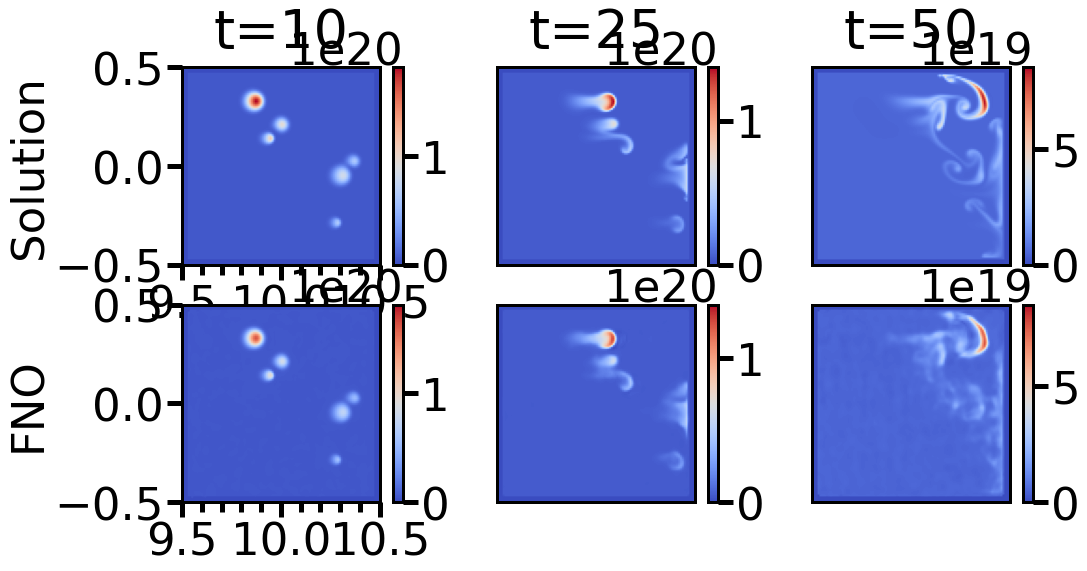

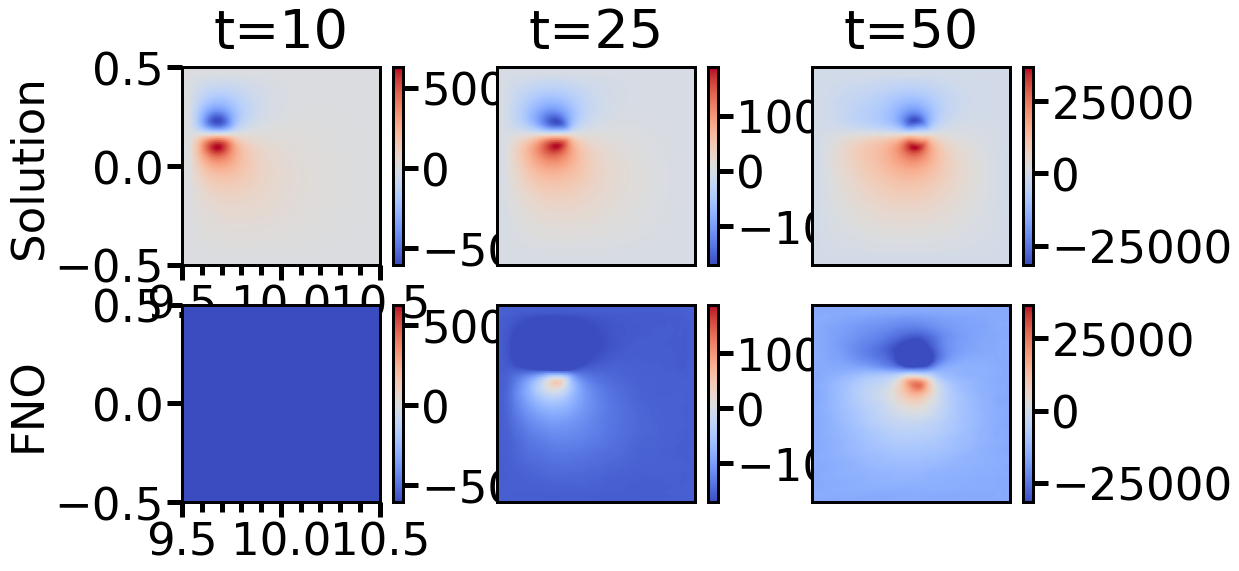

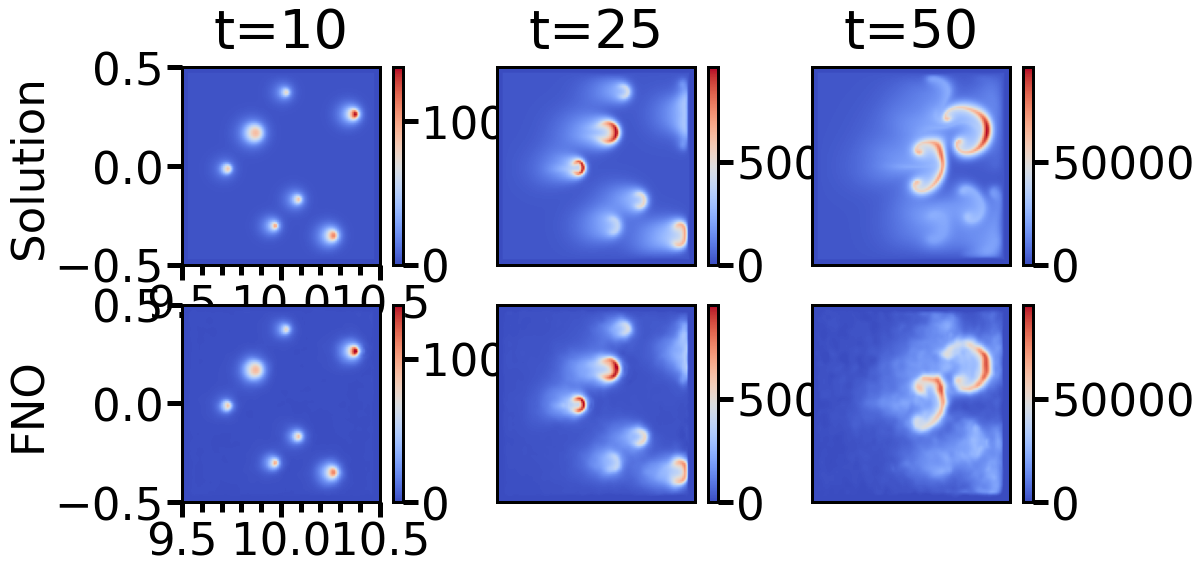

In [65]:
################################################################
# Preparing Data 
################################################################

errs = []
for field in dims:  
    print(field)
        
    if field == 'Phi':
        u_sol = np.load(data)['Phi'].astype(np.float32)   / 1e5
    elif field == 'T':
        u_sol = np.load(data)['T'].astype(np.float32)     / 1e6
    elif field == 'rho':
        u_sol = np.load(data)['rho'].astype(np.float32)   / 1e20

    if configuration['Log Normalisation'] == 'Yes':
        u_sol = np.log(u_sol)

    u_sol = np.nan_to_num(u_sol)
    # u_sol = np.delete(u_sol, (11, 160, 222, 273, 303, 357, 620, 797, 983, 1275, 1391, 1458, 1554, 1600, 1613, 1888, 1937, 1946, 1959), axis=0)
    u_sol= np.delete(u_sol, (153, 229), axis=0) #Outlier T values

    x_grid = np.load(data)['Rgrid'][0,:].astype(np.float32)
    y_grid = np.load(data)['Zgrid'][:,0].astype(np.float32)
    t_grid = np.load(data)['time'].astype(np.float32)

    ntrain = 240
    ntest = 36
    S =106  # Grid Size

    #Extracting hyperparameters from the config dict
    modes = configuration['Modes']

    output_size = configuration['Step']
    batch_size = configuration['Batch Size']
    T_in = configuration['T_in']
    T = configuration['T_out']
    step = configuration['Step']
    num_vars = configuration['Variables']
    width_time = configuration['Width_time']
    width_vars = configuration['Width_vars']
    t1 = default_timer()

    #At this stage the data needs to be [Batch_Size, X, Y, T]

    np.random.shuffle(u_sol)
    u = torch.from_numpy(u_sol)
    u = u.permute(0, 2, 3, 1)

    #At this stage the data needs to be [Batch_Size, X, Y, T]

    train_a = u[:ntrain,:,:,:T_in]
    train_u = u[:ntrain,:,:,T_in:T+T_in]

    test_a = u[-ntest:,:,:,:T_in]
    test_u = u[-ntest:,:,:,T_in:T+T_in]


    #Normalising the train and test datasets with the preferred normalisation. 
    norm_strategy = configuration['Normalisation Strategy']

    if norm_strategy == 'Min-Max':
        a_normalizer = MinMax_Normalizer(train_a)
        y_normalizer = MinMax_Normalizer(train_u)

    if norm_strategy == 'Range':
        a_normalizer = RangeNormalizer(train_a)
        y_normalizer = RangeNormalizer(train_u)

    if norm_strategy == 'Gaussian':
        a_normalizer = GaussianNormalizer(train_a)
        y_normalizer = GaussianNormalizer(train_u)


    test_a = a_normalizer.encode(test_a)
    test_u_encoded = y_normalizer.encode(test_u)


    t2 = default_timer()
    print('preprocessing finished, time used:', t2-t1)

    ################################################################
    # training and evaluation
    ################################################################

    #Instantiating the Model. 
    # model = FNO(modes, modes, width)
    num_vars = 1
    model = FNO_multi(T_in, step, num_vars, modes, modes, width_vars, width_time)

    if field == 'rho':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_fundamental-mesh.pth', map_location=torch.device('cpu')))
    if field == 'Phi':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_some-locker.pth', map_location=torch.device('cpu')))
    if field == 'T':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_covering-cube.pth', map_location=torch.device('cpu')))
    model.to(device)

    run.update_metadata({'Number of Params': int(model.count_params())})
    print("Number of model params : " + str(model.count_params()))

    if torch.cuda.is_available():
        y_normalizer.cuda()

    # Testing
    batch_size = 1
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a.unsqueeze(1), test_u_encoded.unsqueeze(1)), batch_size=1,
                                            shuffle=False)
    pred_set = torch.zeros(test_u.shape)
    index = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx, yy = xx.to(device), yy.to(device)
            # xx = additive_noise(xx)
            t1 = default_timer()
            for t in range(0, T, step):
                y = yy[..., t:t + step]
                out = model(xx)

                if t == 0:
                    pred = out
                else:
                    pred = torch.cat((pred, out), -1)

                xx = torch.cat((xx[..., step:], out), dim=-1)

            t2 = default_timer()
            # pred = y_normalizer.decode(pred)
            pred_set[index] = pred
            index += 1
            # print(t2 - t1)

    #Logging Metrics 
    MSE_error = (pred_set - test_u_encoded).pow(2).mean()
    MAE_error = torch.abs(pred_set - test_u_encoded).mean()
    # LP_error = loss / (ntest*T/step)
    # rel_error = torch.abs((pred_set - test_u_encoded)/test_u_encoded).mean() * 100 



    print('(MSE) Testing Error: %.3e' % (MSE_error))
    print('(MAE) Testing Error: %.3e' % (MAE_error))
    # print('(LP) Testing Error: %.3e' % (LP_error))
    # print('(MAPE) Testing Error %.3e' % (rel_error))
    # print('(NMSE) Testing Error %.3e' % (nmse))
    # print('(NRMSE) Testing Error %.3e' % (nrmse))

    # run.update_metadata({'MSE Test Error': float(MSE_error),
    #                     'MAE Test Error': float(MAE_error),
    #                     'LP Test Error': float(LP_error)
    #                     })

    pred_set_encoded = pred_set
    pred_set = y_normalizer.decode(pred_set.to(device)).cpu()
    pred_set_scaled = pred_set
    test_u_scaled = test_u

    nmse = ((pred_set_scaled - test_u_scaled).pow(2).mean() / test_u_scaled.pow(2).mean())
    print('(NMSE) Testing Error %.3e' % (nmse))



    if configuration["Physics Normalisation"] == 'Yes':
        if field == 'rho':
            pred_set = pred_set * 1e20
            test_u = test_u * 1e20
        if field == 'Phi':
            pred_set = pred_set * 1e5
            test_u = test_u * 1e5
        if field == 'T':
            pred_set= pred_set * 1e6
            test_u = test_u * 1e6

    #Plotting the comparison plots

    idx = np.random.randint(0,ntest) 
    # idx = 3
    idx = 15

    if configuration['Log Normalisation'] == 'Yes':
        test_u = torch.exp(test_u)
        pred_set = torch.exp(pred_set)

    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[:,:,0])
    v_max_1 = torch.max(u_field[:,:,0])

    v_min_2 = torch.min(u_field[:, :, int(T/2)])
    v_max_2 = torch.max(u_field[:, :, int(T/2)])

    v_min_3 = torch.min(u_field[:, :, -1])
    v_max_3 = torch.max(u_field[:, :, -1])

    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(2,3,1)
    pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution')
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,2)
    pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,3)
    pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    u_field = pred_set[idx]

    ax = fig.add_subplot(2,3,4)
    pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO')

    fig.colorbar(pcm, pad=0.05)

    ax = fig.add_subplot(2,3,5)
    pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,6)
    pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)

    #Plotting the error growth across time.
    err = [] 

    for ii in range(T):
        err.append((pred_set_scaled[...,ii] - test_u_scaled[...,ii]).pow(2).mean() / test_u_scaled.pow(2).mean())
    print(test_u_scaled.pow(2).mean())
    err = np.asarray(err)
    errs.append(err)

In [66]:
# plt.plot(np.arange(T_in, T_in + T), err, label=field + ' - solo', alpha=0.8,  color = 'tab:brown')
# plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density', alpha=0.8,  color = 'tab:blue')
# # plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential', alpha=0.8,  color = 'tab:orange')
# # plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp', alpha=0.8,  color = 'tab:green')
# # plt.plot(np.arange(T_in, T_in + T), (err_rho+err_phi+err_T), label='Cumulative', alpha=0.8,  color = 'tab:red', ls='--')
# plt.legend()
# plt.xlabel('Time Steps')
# plt.ylabel('NMAE ')

In [67]:
err_rho_solo, err_phi_solo, err_T_solo = errs[0], errs[1], errs[2]

Text(0, 0.5, 'NMSE ')

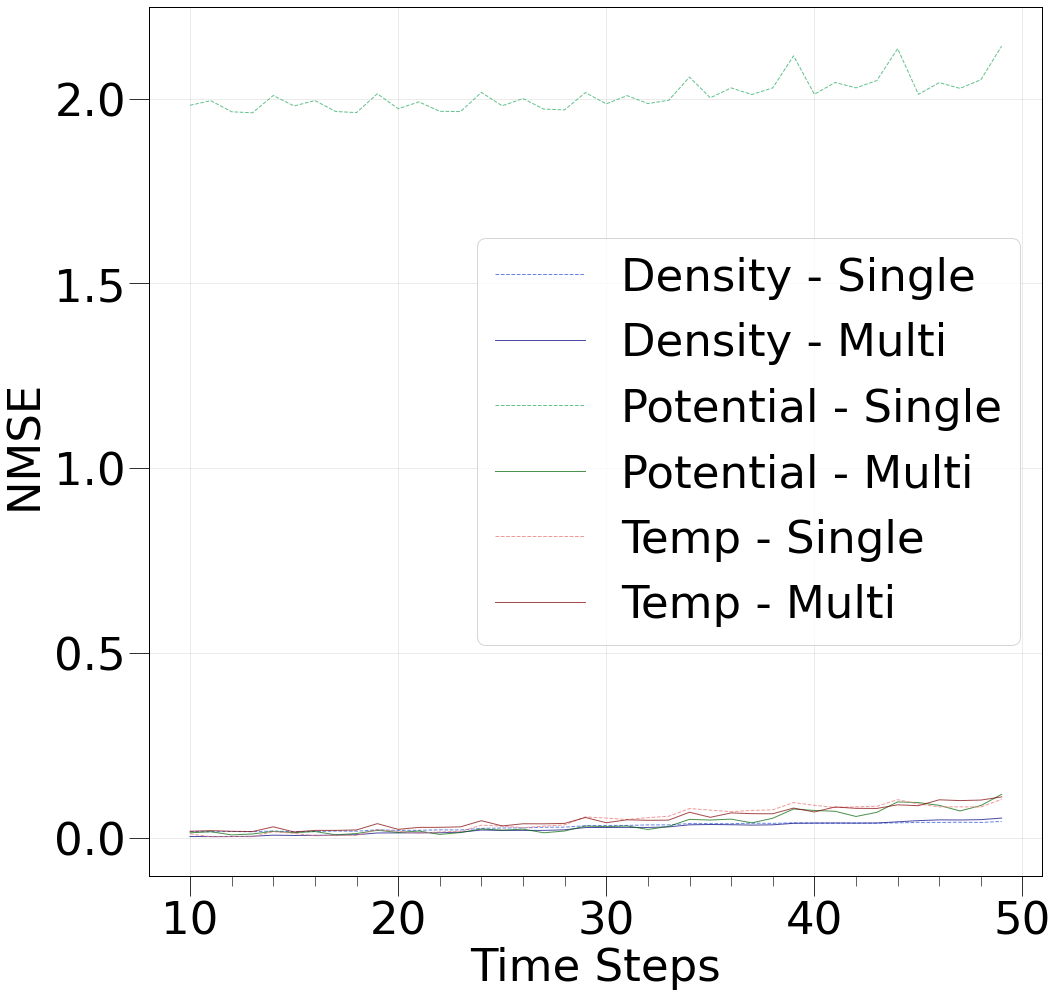

In [68]:
import matplotlib as mpl

plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '-'
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=45
mpl.rcParams['figure.figsize']=(16,16)
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 1
mpl.rcParams['axes.titlepad'] = 30
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['ytick.major.size'] = 20
plt.rcParams['xtick.minor.size'] = 10.0
plt.rcParams['ytick.minor.size'] = 10.0
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.minor.width'] = 0.6
mpl.rcParams['lines.linewidth'] = 1
plt.figure()
plt.grid()
plt.plot(np.arange(T_in, T_in + T), err_rho_solo, label='Density - Single', alpha=0.8,  color = 'royalblue', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density - Multi', alpha=0.7,  color = 'navy')
plt.plot(np.arange(T_in, T_in + T), err_phi_solo, label='Potential - Single', alpha=0.8,  color = 'mediumseagreen', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential - Multi', alpha=0.7,  color = 'darkgreen')
plt.plot(np.arange(T_in, T_in + T), err_T_solo, label='Temp - Single', alpha=0.8,  color = 'lightcoral', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp - Multi', alpha=0.7,  color = 'maroon')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('NMSE ')

# plt.savefig("multiblobs_error_growth.pdf", bbox_inches='tight')
# plt.savefig("multiblobs_error_growth.svg", bbox_inches='tight')

In [69]:
configuration = {"Case": 'Multi-Blobs',
                 "Field": 'rho, Phi, T',
                 "Field_Mixing": 'Channel',
                 "Type": '2D Time',
                 "Epochs": 0,
                 "Batch Size": 4,
                 "Optimizer": 'Adam',
                 "Learning Rate": 0.005,
                 "Scheduler Step": 100,
                 "Scheduler Gamma": 0.5,
                 "Activation": 'GELU',
                 "Normalisation Strategy": 'Min-Max. Single',
                 "Instance Norm": 'No',
                 "Log Normalisation":  'No',
                 "Physics Normalisation": 'Yes',
                 "T_in": 10,    
                 "T_out": 40,
                 "Step": 5,
                 "Modes": 16,
                 "Width_time":32, #FNO
                 "Width_vars": 0, #U-Net
                 "Variables":3, 
                 "Noise":0.0, 
                 "Loss Function": 'LP Loss',
                 "Spatial Resolution": 1,
                 "Temporal Resolution": 1,
                #  "UQ": 'Dropout',
                #  "Dropout Rate": 0.9
                 }

In [70]:
from simvue import Run
run = Run(mode='disabled')
run.init(folder="/FNO_MHD", tags=['FNO', 'MHD', 'JOREK', 'Multi-Blobs', 'MultiVariable'], metadata=configuration)

True

In [71]:
import os 
CODE = ['FNO_multiple.py']
# Save code files
for code_file in CODE:
    if os.path.isfile(code_file):
        run.save(code_file, 'code')
    elif os.path.isdir(code_file):
        run.save_directory(code_file, 'code', 'text/plain', preserve_path=True)
    else:
        print('ERROR: code file %s does not exist' % code_file)

In [72]:
import numpy as np
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import cm 

import operator
from functools import reduce
from functools import partial
from collections import OrderedDict

import time 
from timeit import default_timer
from tqdm import tqdm 

torch.manual_seed(0)
np.random.seed(0)

In [73]:
path = os.getcwd()
data_loc = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
# model_loc = os.path.dirname(os.path.dirname(os.getcwd()))
file_loc = os.getcwd()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
##################################
#Normalisation Functions 
##################################


# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=-1.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x


    def cuda(self):
        self.a = self.a.cuda()
        self.b = self.b.cuda()

    def cpu(self):
        self.a = self.a.cpu()
        self.b = self.b.cpu()

# #normalization, rangewise but single value. 


# normalization, rangewise but single value.
class MinMax_Normalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(MinMax_Normalizer, self).__init__()
        min_u = torch.min(x[:, 0, :, :, :])
        max_u = torch.max(x[:, 0, :, :, :])

        self.a_u = (high - low) / (max_u - min_u)
        self.b_u = -self.a_u * max_u + high

        min_v = torch.min(x[:, 1, :, :, :])
        max_v = torch.max(x[:, 1, :, :, :])

        self.a_v = (high - low) / (max_v - min_v)
        self.b_v = -self.a_v * max_v + high

        min_p = torch.min(x[:, 2, :, :, :])
        max_p = torch.max(x[:, 2, :, :, :])

        self.a_p = (high - low) / (max_p - min_p)
        self.b_p = -self.a_p * max_p + high

    def encode(self, x):
        s = x.size()

        u = x[:, 0, :, :, :]
        u = self.a_u * u + self.b_u

        v = x[:, 1, :, :, :]
        v = self.a_v * v + self.b_v

        p = x[:, 2, :, :, :]
        p = self.a_p * p + self.b_p

        x = torch.stack((u, v, p), dim=1)

        return x

    def decode(self, x):
        s = x.size()

        u = x[:, 0, :, :, :]
        u = (u - self.b_u) / self.a_u

        v = x[:, 1, :, :, :]
        v = (v - self.b_v) / self.a_v

        p = x[:, 2, :, :, :]
        p = (p - self.b_p) / self.a_p

        x = torch.stack((u, v, p), dim=1)

        return x

    def cuda(self):
        self.a_u = self.a_u.cuda()
        self.b_u = self.b_u.cuda()

        self.a_v = self.a_v.cuda()
        self.b_v = self.b_v.cuda()

        self.a_p = self.a_p.cuda()
        self.b_p = self.b_p.cuda()

    def cpu(self):
        self.a_u = self.a_u.cpu()
        self.b_u = self.b_u.cpu()

        self.a_v = self.a_v.cpu()
        self.b_v = self.b_v.cpu()

        self.a_p = self.a_p.cpu()
        self.b_p = self.b_p.cpu()


        

# #normalization, rangewise but across the full domain 
# class MinMax_Normalizer(object):
#     def __init__(self, x, low=-1.0, high=1.0):
#         super(MinMax_Normalizer, self).__init__()
#         mymin = torch.min(x)
#         mymax = torch.max(x)

#         self.a = (high - low)/(mymax - mymin)
#         self.b = -self.a*mymax + high

#     def encode(self, x):
#         s = x.size()
#         x = x.reshape(s[0], -1)
#         x = self.a*x + self.b
#         x = x.view(s)
#         return x

#     def decode(self, x):
#         s = x.size()
#         x = x.reshape(s[0], -1)
#         x = (x - self.b)/self.a
#         x = x.view(s)
#         return x

#     def cuda(self):
#         self.a = self.a.cuda()
#         self.b = self.b.cuda()

#     def cpu(self):
#         self.a = self.a.cpu()
#         self.b = self.b.cpu()

In [75]:
##################################
# Loss Functions
##################################

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [76]:
x_grid = np.arange(0, 106)
y_grid = np.arange(0, 106)
S = 106 #Grid Size
size_x = S
size_y = S


modes = configuration['Modes']
width_time = configuration['Width_time']
width_vars = configuration['Width_vars']
output_size = configuration['Step']

batch_size = configuration['Batch Size']

batch_size2 = batch_size

t1 = default_timer()

T_in = configuration['T_in']
T = configuration['T_out']
step = configuration['Step']
num_vars = configuration['Variables']

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [78]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, num_vars):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.num_vars = num_vars

        self.scale = (1 / (in_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, num_vars, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, num_vars, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bivxy,iovxy->bovxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, self.num_vars, x.size(-2), x.size(-1) // 2 + 1,
                             dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv3d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv3d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, num_vars):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.num_vars = num_vars

        self.conv = SpectralConv2d(self.width, self.width, self.modes1, self.modes2, self.num_vars)
        self.mlp = MLP(self.width, self.width, self.width)
        self.w = nn.Conv3d(self.width, self.width, 1)
        self.b = nn.Conv3d(2, self.width, 1)

    def forward(self, x, grid):
        x1 = self.conv(x)
        x1 = self.mlp(x1)
        x2 = self.w(x)
        x3 = self.b(grid)
        x = x1 + x2 + x3
        x = F.gelu(x)
        return x

In [79]:
class FNO_multi(nn.Module):
    def __init__(self,T_in, step, num_vars, modes1, modes2, width_vars, width_time):
        super(FNO_multi, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous T_in timesteps + 2 locations (u(t-T_in, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=x_discretistion, y=y_discretisation, c=T_in)
        output: the solution of the next timestep
        output shape: (batchsize, x=x_discretisation, y=y_discretisatiob, c=step)
        """
        self.T_in = T_in
        self.step = step 
        self.num_vars = num_vars
        self.modes1 = modes1
        self.modes2 = modes2
        self.width_vars = width_vars
        self.width_time = width_time

        self.fc0_time = nn.Linear(self.T_in + 2, self.width_time)

        # self.padding = 8 # pad the domain if input is non-periodic

        self.f0 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f1 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f2 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f3 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f4 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)
        self.f5 = FNO2d(self.modes1, self.modes2, self.width_time, self.num_vars)

        # self.norm = nn.InstanceNorm2d(self.width)
        self.norm = nn.Identity()

        self.fc1_time = nn.Linear(self.width_time, 256)
        self.fc2_time = nn.Linear(256, self.step)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)

        x = self.fc0_time(x)
        x = x.permute(0, 4, 1, 2, 3)
        grid = grid.permute(0, 4, 1, 2, 3)
        # x = self.dropout(x)

        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x0 = self.f0(x, grid)
        x = self.f1(x0, grid)
        x = self.f2(x, grid) + x0
        x1 = self.f3(x, grid)
        x = self.f4(x1, grid)
        x = self.f5(x, grid) + x1

        # x = self.dropout(x)

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic

        x = x.permute(0, 2, 3, 4, 1)
        x = x

        x = self.fc1_time(x)
        x = F.gelu(x)
        # x = self.dropout(x)
        x = self.fc2_time(x)

        return x

    # Using x and y values from the simulation discretisation
    def get_grid(self, shape, device):
        batchsize, num_vars, size_x, size_y = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(9.5, 10.5, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1, 1).repeat([batchsize, num_vars, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(-0.5, 0.5, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y, 1).repeat([batchsize, num_vars, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

    ## Arbitrary grid discretisation
    # def get_grid(self, shape, device):
    #     batchsize, size_x, size_y = shape[0], shape[1], shape[2]
    #     gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
    #     gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
    #     gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
    #     gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
    #     return torch.cat((gridx, gridy), dim=-1).to(device)

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [80]:
################################################################
# Loading Data 
################################################################

In [81]:
data = data_loc + '/Data/MHD_multi_blobs.npz'
# data = data_loc + '/Data/FNO_MHD_data_multi_blob_2000_T50.npz'# new dataset

In [82]:
field = configuration['Field']
dims = ['rho', 'Phi', 'T']
num_vars = configuration['Variables']

u_sol = np.load(data)['rho'].astype(np.float32)  / 1e20
v_sol = np.load(data)['Phi'].astype(np.float32)  / 1e5
p_sol = np.load(data)['T'].astype(np.float32)    / 1e6

u_sol = np.nan_to_num(u_sol)
v_sol = np.nan_to_num(v_sol)
p_sol = np.nan_to_num(p_sol)

u = torch.from_numpy(u_sol)
u = u.permute(0, 2, 3, 1)

v = torch.from_numpy(v_sol)
v = v.permute(0, 2, 3, 1)

p = torch.from_numpy(p_sol)
p = p.permute(0, 2, 3, 1)

t_res = configuration['Temporal Resolution']
x_res = configuration['Spatial Resolution']
uvp = torch.stack((u,v,p), dim=1)[:,::t_res]
uvp = np.delete(uvp, (153, 229), axis=0)  # Outlier T values
# uvp = np.delete(uvp, (11, 160, 222, 273, 303, 357, 620, 797, 983, 1275, 1391, 1458, 1554, 1600, 1613, 1888, 1937, 1946, 1959), axis=0) #Only for the new dataset 
    
np.random.shuffle(uvp)

x_grid = np.load(data)['Rgrid'][0,:].astype(np.float32)
y_grid = np.load(data)['Zgrid'][:,0].astype(np.float32)
t_grid = np.load(data)['time'].astype(np.float32)

ntrain =240
ntest = 36

# ntrain = 1500 #new dataset
# ntest = 85 #new dataset

S = 106 #Grid Size
size_x = S
size_y = S

batch_size = configuration['Batch Size']

batch_size2 = batch_size

t1 = default_timer()



train_a = uvp[:ntrain,:,:,:,:T_in]
train_u = uvp[:ntrain,:,:,:,T_in:T+T_in]

test_a = uvp[-ntest:,:,:,:,:T_in]
test_u = uvp[-ntest:,:,:,:,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)

torch.Size([240, 3, 106, 106, 40])
torch.Size([36, 3, 106, 106, 40])


/home/ir-gopa2/rds/rds-ukaea-ap001/ir-gopa2/Code/Fourier_NNs/Multi_Blobs/Plots_zl.py:29: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  "Modes": 16,


In [83]:
# a_normalizer = RangeNormalizer(train_a)
a_normalizer = MinMax_Normalizer(train_a)
# a_normalizer = GaussianNormalizer(train_a)

train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

# y_normalizer = RangeNormalizer(train_u)
y_normalizer = MinMax_Normalizer(train_u)
# y_normalizer = GaussianNormalizer(train_u)

train_u = y_normalizer.encode(train_u)
test_u_encoded = y_normalizer.encode(test_u)

In [84]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u_encoded), batch_size=batch_size, shuffle=False)

t2 = default_timer()
print('preprocessing finished, time used:', t2-t1)

preprocessing finished, time used: 4.357729230076075


In [85]:
################################################################
# training and evaluation
################################################################

# model = FNO_multi(16, 16, width_vars, width_time)
model = FNO_multi(T_in, step, num_vars, modes, modes, width_vars, width_time)

# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_weary-tactics.pth', map_location=torch.device('cpu'))) #Min-Max Diff
# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_polite-comment.pth', map_location=torch.device('cpu'))) #Min-Max Same 
model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_dynamic-duck.pth', map_location=torch.device('cpu'))) #Min-Max Diff

model.to(device)

run.update_metadata({'Number of Params': int(model.count_params())})
print("Number of model params : " + str(model.count_params()))

Number of model params : 9466917


In [86]:
epochs = configuration['Epochs']
if torch.cuda.is_available():
    y_normalizer.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=configuration['Learning Rate'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=configuration['Scheduler Step'], gamma=configuration['Scheduler Gamma'])

myloss = LpLoss(size_average=False)

In [87]:
epochs = configuration['Epochs']
if torch.cuda.is_available():
    y_normalizer.cuda()

In [88]:
#Testing 
batch_size = 1
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u_encoded), batch_size=1, shuffle=False)
pred_set = torch.zeros(test_u.shape)
index = 0
with torch.no_grad():
    for xx, yy in tqdm(test_loader):
        loss = 0
        xx, yy = xx.to(device), yy.to(device)
        # xx = additive_noise(xx)
        t1 = default_timer()
        for t in range(0, T, step):
            y = yy[..., t:t + step]
            out = model(xx)
            loss += myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = out
            else:
                pred = torch.cat((pred, out), -1)       

            xx = torch.cat((xx[..., step:], out), dim=-1)

        t2 = default_timer()
        # pred = y_normalizer.decode(pred)
        pred_set[index]=pred
        index += 1
        print(t2-t1)

  3%|▎         | 1/36 [00:02<01:13,  2.09s/it]

2.0907067030202597


  6%|▌         | 2/36 [00:04<01:11,  2.10s/it]

2.1014400189742446


  8%|▊         | 3/36 [00:06<01:12,  2.19s/it]

2.2854588800109923


 11%|█         | 4/36 [00:08<01:11,  2.22s/it]

2.2766646130476147


 14%|█▍        | 5/36 [00:11<01:09,  2.24s/it]

2.265425511985086


 17%|█▋        | 6/36 [00:13<01:07,  2.24s/it]

2.2402482100296766


 19%|█▉        | 7/36 [00:15<01:05,  2.26s/it]

2.296120782964863


 22%|██▏       | 8/36 [00:17<01:02,  2.25s/it]

2.2101181220496073


 25%|██▌       | 9/36 [00:19<00:59,  2.19s/it]

2.071547345025465


 28%|██▊       | 10/36 [00:21<00:56,  2.16s/it]

2.0844349439721555


 31%|███       | 11/36 [00:24<00:53,  2.14s/it]

2.08695030992385


 33%|███▎      | 12/36 [00:26<00:50,  2.12s/it]

2.0648844209499657


 36%|███▌      | 13/36 [00:28<00:48,  2.11s/it]

2.079608656000346


 39%|███▉      | 14/36 [00:30<00:46,  2.11s/it]

2.105911015998572


 42%|████▏     | 15/36 [00:32<00:44,  2.11s/it]

2.107996915001422


 44%|████▍     | 16/36 [00:34<00:42,  2.10s/it]

2.0834252620115876


 47%|████▋     | 17/36 [00:36<00:40,  2.11s/it]

2.1078527229838073


 50%|█████     | 18/36 [00:38<00:37,  2.10s/it]

2.080689762951806


 53%|█████▎    | 19/36 [00:40<00:35,  2.10s/it]

2.08175981300883


 56%|█████▌    | 20/36 [00:42<00:33,  2.09s/it]

2.072398395044729


 58%|█████▊    | 21/36 [00:44<00:31,  2.10s/it]

2.116876154905185


 61%|██████    | 22/36 [00:47<00:32,  2.33s/it]

2.8560945419594646


 64%|██████▍   | 23/36 [00:49<00:29,  2.25s/it]

2.0539675230393186


 67%|██████▋   | 24/36 [00:51<00:26,  2.19s/it]

2.04639519599732


 69%|██████▉   | 25/36 [00:54<00:23,  2.15s/it]

2.04692505300045


 72%|███████▏  | 26/36 [00:56<00:21,  2.12s/it]

2.070809828932397


 75%|███████▌  | 27/36 [00:58<00:18,  2.10s/it]

2.0496455560205504


 78%|███████▊  | 28/36 [01:00<00:16,  2.09s/it]

2.0708453920669854


 81%|████████  | 29/36 [01:02<00:14,  2.09s/it]

2.081920712022111


 83%|████████▎ | 30/36 [01:04<00:12,  2.08s/it]

2.052237653057091


 86%|████████▌ | 31/36 [01:06<00:10,  2.08s/it]

2.08285004098434


 89%|████████▉ | 32/36 [01:08<00:08,  2.08s/it]

2.054250306915492


 92%|█████████▏| 33/36 [01:10<00:06,  2.07s/it]

2.062409795005806


 94%|█████████▍| 34/36 [01:12<00:04,  2.07s/it]

2.052989677991718


 97%|█████████▋| 35/36 [01:14<00:02,  2.07s/it]

2.0734255940187722


100%|██████████| 36/36 [01:16<00:00,  2.13s/it]

2.0819035989698023


In [89]:
print(pred_set.shape, test_u.shape)
#Logging Metrics 
MSE_error = (pred_set - test_u_encoded).pow(2).mean()
MAE_error = torch.abs(pred_set - test_u_encoded).mean()
LP_error = loss / (ntest*T/step)
rel_error = torch.abs((pred_set - test_u_encoded)/test_u_encoded).mean() * 100 
nmse = ((pred_set - test_u_encoded).pow(2).mean() / test_u_encoded.pow(2).mean())
nrmse = torch.sqrt((pred_set - test_u_encoded).pow(2).mean()) / torch.std(test_u_encoded)

print('(MSE) Testing Error: %.3e' % (MSE_error))
print('(MAE) Testing Error: %.3e' % (MAE_error))
# print('(LP) Testing Error: %.3e' % (LP_error))
# print('(MAPE) Testing Error %.3e' % (rel_error))
# print('(NMSE) Testing Error %.3e' % (nmse))
# print('(NRMSE) Testing Error %.3e' % (nrmse))

# run.update_metadata({'MSE Test Error': float(MSE_error),
#                      'MAE Test Error': float(MAE_error),
#                      'LP Test Error': float(LP_error)
#                     })


pred_set_encoded = pred_set
pred_set = y_normalizer.decode(pred_set.to(device)).cpu()

nmse= 0 
for ii in range(num_vars):
    nmse += (pred_set[:,ii] - test_u[:,ii]).pow(2).mean() / test_u[:,ii].pow(2).mean()
    print(test_u[:,ii].pow(2).mean())
nmse = nmse/num_vars
print('(NMSE) Testing Error %.3e' % (nmse))

pred_set_scaled = pred_set
test_u_scaled = test_u

torch.Size([36, 3, 106, 106, 40]) torch.Size([36, 3, 106, 106, 40])
(MSE) Testing Error: 4.668e-05
(MAE) Testing Error: 3.332e-03
tensor(0.0116)
tensor(0.0115)
tensor(0.0002)
(NMSE) Testing Error 3.835e-02


In [90]:
#Plotting the error growth across time.
err_rho = [] 
err_phi = []
err_T = []

for ii in range(T):
    err_rho.append((pred_set_scaled[:,0,:,:,ii] - test_u_scaled[:,0,:,:,ii]).pow(2).mean() / test_u_scaled[:,0].pow(2).mean())
    err_phi.append((pred_set_scaled[:,1,:,:,ii] - test_u_scaled[:,1,:,:,ii]).pow(2).mean() / test_u_scaled[:,1].pow(2).mean())
    err_T.append((pred_set_scaled[:,2,:,:,ii] - test_u_scaled[:,2,:,:,ii]).pow(2).mean() / test_u_scaled[:,2].pow(2).mean())

err_rho = np.asarray(err_rho)
err_phi = np.asarray(err_phi)
err_T = np.asarray(err_T)

In [91]:
if configuration["Physics Normalisation"] == 'Yes':
    pred_set[:,0:1,...] = pred_set[:,0:1,...] * 1e20
    pred_set[:,1:2,...] = pred_set[:,1:2,...] * 1e5
    pred_set[:,2:3,...] = pred_set[:,2:3,...] * 1e6


    test_u[:,0:1,...] = test_u[:,0:1,...] * 1e20
    test_u[:,1:2,...] = test_u[:,1:2,...] * 1e5
    test_u[:,2:3,...] = test_u[:,2:3,...] * 1e6

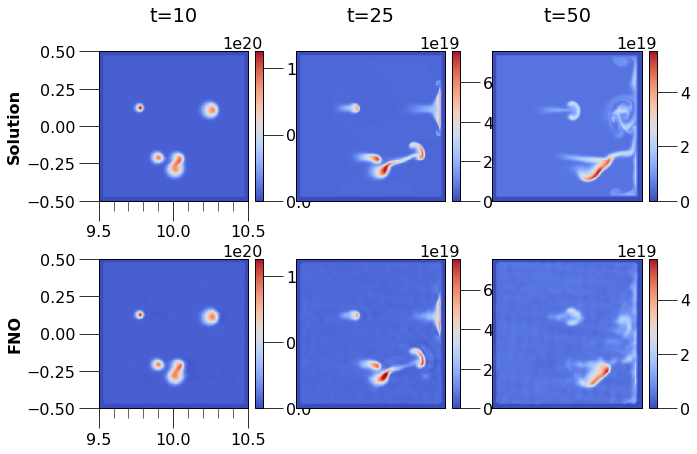

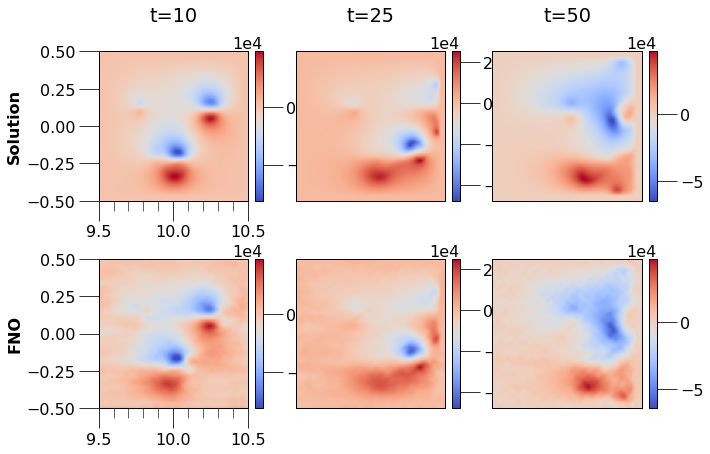

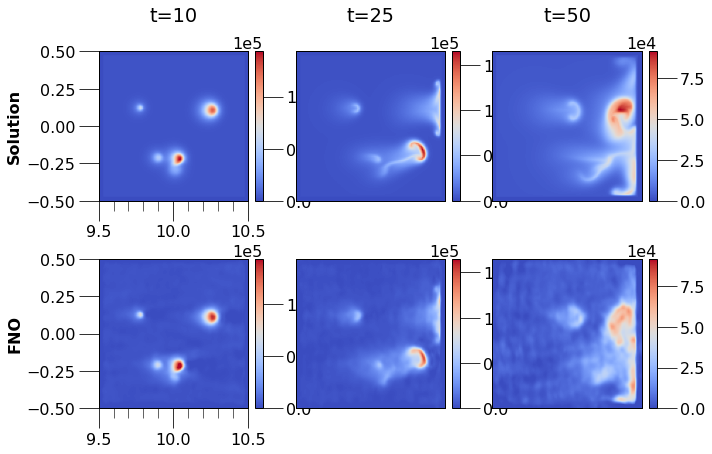

In [92]:
#Plotting the comparison plots
idx = np.random.randint(0,ntest) 
# idx = 5
# idx = 36
# idx = 3
# idx = 5  
idx = 15
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.rcParams['font.size']=16

output_plot = []
for dim in range(num_vars):
    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[dim,:,:,0])
    v_max_1 = torch.max(u_field[dim,:,:,0])

    v_min_2 = torch.min(u_field[dim, :, :, int(T/2)])
    v_max_2 = torch.max(u_field[dim, :, :, int(T/2)])

    v_min_3 = torch.min(u_field[dim, :, :, -1])
    v_max_3 = torch.max(u_field[dim, :, :, -1])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(2,3,1)
    pcm =ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    
    ax = fig.add_subplot(2,3,2)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,3)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = pred_set[idx]

    ax = fig.add_subplot(2,3,4)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,5)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(2,3,6)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

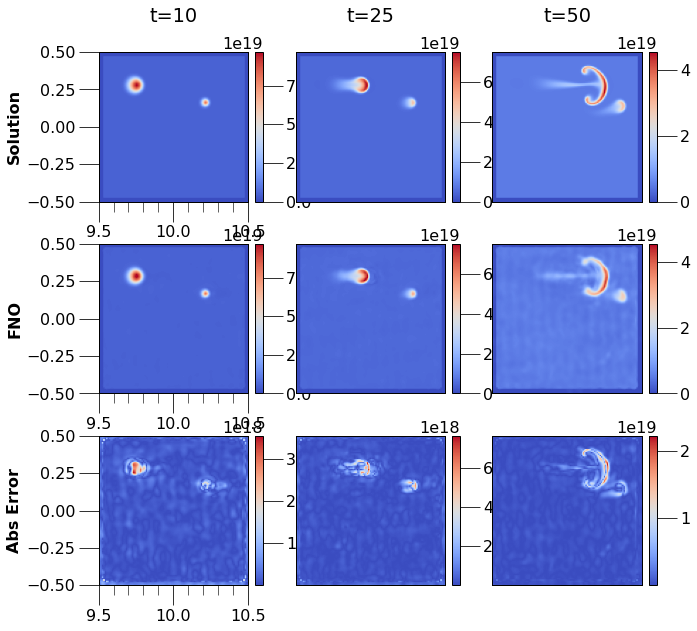

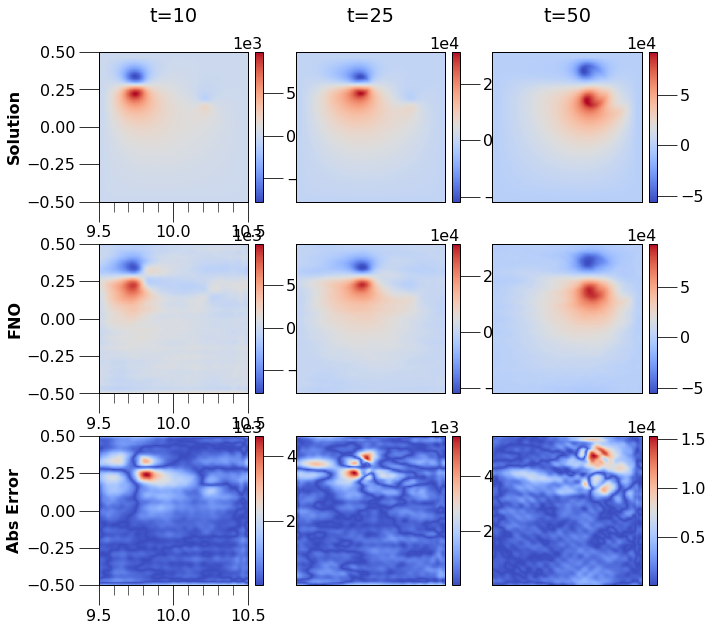

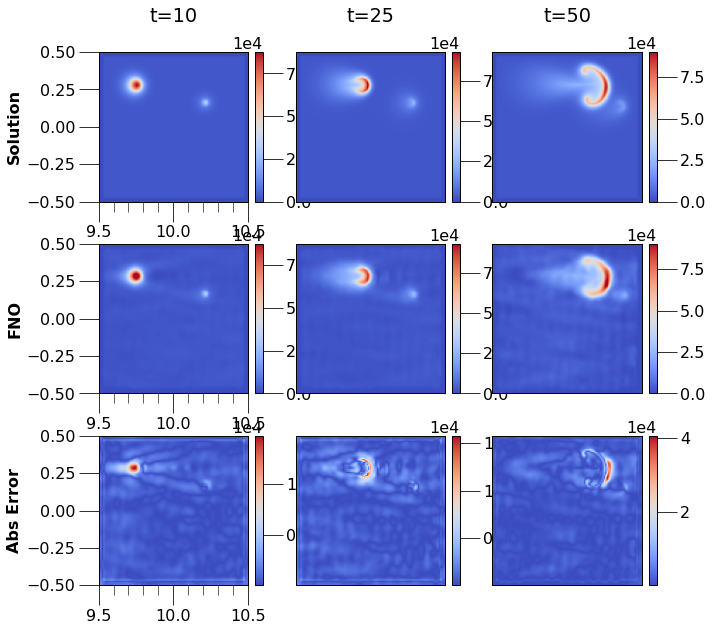

In [93]:
#Error Plots
idx = 8
output_plot = []
for dim in range(num_vars):
    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[dim,:,:,0])
    v_max_1 = torch.max(u_field[dim,:,:,0])

    v_min_2 = torch.min(u_field[dim, :, :, int(T/2)])
    v_max_2 = torch.max(u_field[dim, :, :, int(T/2)])

    v_min_3 = torch.min(u_field[dim, :, :, -1])
    v_max_3 = torch.max(u_field[dim, :, :, -1])

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(3,3,1)
    pcm =ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))
    
    ax = fig.add_subplot(3,3,2)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,3)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = pred_set[idx]

    ax = fig.add_subplot(3,3,4)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,5)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,6)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    u_field = torch.abs(test_u[idx] - pred_set[idx])

    ax = fig.add_subplot(3,3,7)
    pcm = ax.imshow(u_field[dim,:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5])
    ax.set_ylabel('Abs Error', weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,8)
    pcm = ax.imshow(u_field[dim,:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    ax = fig.add_subplot(3,3,9)
    pcm = ax.imshow(u_field[dim,:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax)
    cbar.formatter.set_powerlimits((0, 0))

    # plt.savefig("multiblobs_" + dims[dim] + "_" + str(idx) + "_reduced-fort.pdf", format="pdf", bbox_inches='tight', transparent='True')

In [94]:
import matplotlib as mpl
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '-'
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=45
mpl.rcParams['figure.figsize']=(16,16)
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 3
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
mpl.rcParams['axes.titlepad'] = 20

Text(0, 0.5, 'NMSE ')

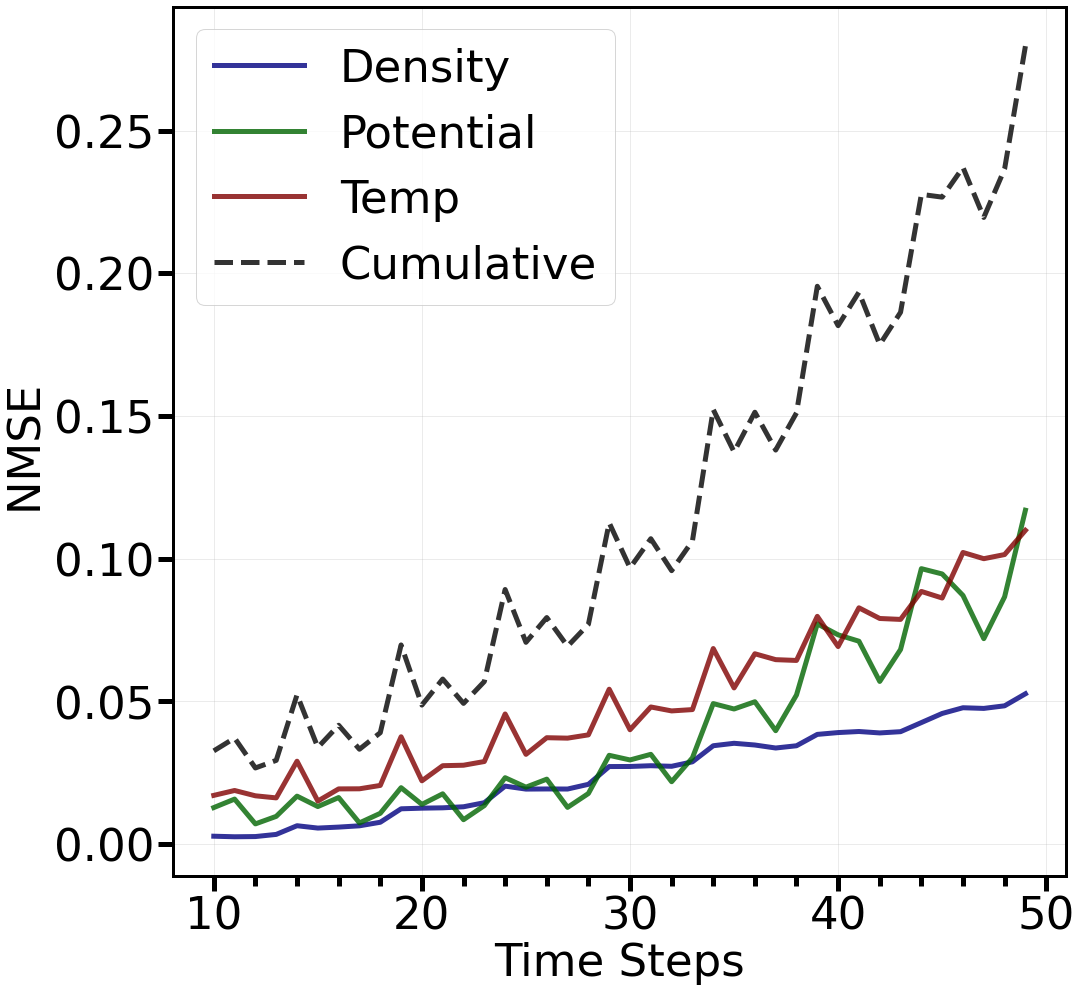

In [95]:
plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density', alpha=0.8,  color = 'navy', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential', alpha=0.8,  color = 'darkgreen', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp', alpha=0.8,  color = 'maroon', linewidth=5)
plt.plot(np.arange(T_in, T_in + T), (err_rho+err_phi+err_T), label='Cumulative', alpha=0.8,  color = 'black', ls='--', linewidth=5)
plt.legend()
plt.grid()
plt.xlabel('Time Steps')
plt.ylabel('NMSE ')

# plt.savefig("multiblobs_error_growth_cum.pdf", bbox_inches='tight')
# plt.savefig("multiblobs_error_growth_cum.svg", bbox_inches='tight')

In [96]:
# #Dropout Plots
# #Cyan-Provolone
# configuration = {"Case": 'Multi-Blobs',
#                  "Field": 'rho, Phi, T',
#                  "Field_Mixing": 'Channel',
#                  "Type": '2D Time',
#                  "Epochs": 500,
#                  "Batch Size": 10,
#                  "Optimizer": 'Adam',
#                  "Learning Rate": 0.005,
#                  "Scheduler Step": 100,
#                  "Scheduler Gamma": 0.5,
#                  "Activation": 'GELU',
#                  "Normalisation Strategy": 'Min-Max',
#                  "Instance Norm": 'No',
#                  "Log Normalisation":  'No',
#                  "Physics Normalisation": 'Yes',
#                  "T_in": 10,    
#                  "T_out": 40,
#                  "Step": 5,
#                  "Modes":16,
#                  "Width_time":32, #FNO
#                  "Width_vars": 0, #U-Net
#                  "Variables":3, 
#                  "Noise":0.0, 
#                  "Loss Function": 'LP Loss',
#                  "Spatial Resolution": 1,
#                  "Temporal Resolution": 1,
#                  "UQ": 'Dropout',
#                  "Dropout Rate": 0.9
#                  }

# T_in  = configuration['T_in']
# T_out = configuration['T_out']
# step = configuration['Step']
# modes = configuration['Modes']
# width_vars = configuration['Width_vars']
# width_time = configuration['Width_time']


# class FNO_multi_dropout(nn.Module):
#     def __init__(self, modes1, modes2, width_vars, width_time):
#         super(FNO_multi_dropout, self).__init__()

#         """
#         The overall network. It contains 4 layers of the Fourier layer.
#         1. Lift the input to the desire channel dimension by self.fc0 .
#         2. 4 layers of the integral operators u' = (W + K)(u).
#             W defined by self.w; K defined by self.conv .
#         3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
#         input: the solution of the previous T_in timesteps + 2 locations (u(t-T_in, x, y), ..., u(t-1, x, y),  x, y)
#         input shape: (batchsize, x=x_discretistion, y=y_discretisation, c=T_in)
#         output: the solution of the next timestep
#         output shape: (batchsize, x=x_discretisation, y=y_discretisatiob, c=step)
#         """

#         self.modes1 = modes1
#         self.modes2 = modes2
#         self.width_vars = width_vars
#         self.width_time = width_time

#         self.fc0_time  = nn.Linear(T_in+2, self.width_time)

#         # self.padding = 8 # pad the domain if input is non-periodic

#         self.f0 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f1 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f2 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f3 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f4 = FNO2d(self.modes1, self.modes2, self.width_time)
#         self.f5 = FNO2d(self.modes1, self.modes2, self.width_time)

#         self.dropout = nn.Dropout(p=0.1)

#         # self.norm = nn.InstanceNorm2d(self.width)
#         self.norm = nn.Identity()


#         self.fc1_time = nn.Linear(self.width_time, 128)
#         self.fc2_time = nn.Linear(128, step)


#     def forward(self, x):
#         grid = self.get_grid(x.shape, x.device)
#         x = torch.cat((x, grid), dim=-1)


#         x = self.fc0_time(x)
#         x = x.permute(0, 4, 1, 2, 3)
#         x = self.dropout(x)

#         # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

#         x0 = self.f0(x)
#         x = self.f1(x0)
#         x = self.f2(x) + x0 
#         x = self.dropout(x)
#         x1 = self.f3(x)
#         x = self.f4(x1)
#         x = self.f5(x) + x1 
#         x = self.dropout(x)

#         # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic

#         x = x.permute(0, 2, 3, 4, 1)
#         x = x 

#         x = self.fc1_time(x)
#         x = F.gelu(x)
#         x = self.dropout(x)
#         x = self.fc2_time(x)
        
#         return x

# #Using x and y values from the simulation discretisation 
#     def get_grid(self, shape, device):
#         batchsize, num_vars, size_x, size_y = shape[0], shape[1], shape[2], shape[3]
#         gridx = gridx = torch.tensor(x_grid, dtype=torch.float)
#         gridx = gridx.reshape(1, 1, size_x, 1, 1).repeat([batchsize, num_vars, 1, size_y, 1])
#         gridy = torch.tensor(y_grid, dtype=torch.float)
#         gridy = gridy.reshape(1, 1, 1, size_y, 1).repeat([batchsize, num_vars, size_x, 1, 1])
#         return torch.cat((gridx, gridy), dim=-1).to(device)

# ## Arbitrary grid discretisation 
#     # def get_grid(self, shape, device):
#     #     batchsize, size_x, size_y = shape[0], shape[1], shape[2]
#     #     gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
#     #     gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
#     #     gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
#     #     gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
#     #     return torch.cat((gridx, gridy), dim=-1).to(device)


#     def count_params(self):
#         c = 0
#         for p in self.parameters():
#             c += reduce(operator.mul, list(p.size()))

#         return c

# model = FNO_multi_dropout(modes, modes, width_vars, width_time)
# model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_cyan-provolone.pth', map_location=torch.device('cpu')))
# model.to(device)



# # %%
# #Extracting the Mean and Variance across the time roll out to plot later. 

# # %%
# idx = 36
# model.eval()
# xx = test_a[idx:idx+1]
# yy = test_u_encoded[idx:idx+1,:, :,:,:10]
# var = 0 
# preds = []

# for i in tqdm(range(100)):
#         preds.append(model(xx).detach().numpy())

# preds_mean = np.mean(preds, axis=0)
# preds_std = np.std(preds, axis=0)
# # %%
# test_yy= y_normalizer.decode(torch.Tensor(yy)) * 1e20
# preds_mean = y_normalizer.decode(torch.Tensor(preds_mean)).detach().numpy() * 1e20
# preds_std= y_normalizer.decode(torch.Tensor(preds_std)).detach().numpy() * 1e20


# T = step

# u_field = test_yy[0][var]

# v_min_1 = torch.min(u_field[:,:,0])
# v_max_1 = torch.max(u_field[:,:,0])

# v_min_2 = torch.min(u_field[:, :, int(T/2)])
# v_max_2 = torch.max(u_field[:, :, int(T/2)])

# v_min_3 = torch.min(u_field[:, :, -1])
# v_max_3 = torch.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(2,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('Solution')
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# u_field = preds_mean[0][var]

# ax = fig.add_subplot(2,3,4)
# pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# ax.set_ylabel('FNO')

# fig.colorbar(pcm, pad=0.05)

# ax = fig.add_subplot(2,3,5)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,6)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)



# from mpl_toolkits.axes_grid1 import make_axes_locatable

# u_field = preds_std[0][var]

# v_min_1 = np.min(u_field[:,:,0])
# v_max_1 = np.max(u_field[:,:,0])

# v_min_2 = np.min(u_field[:, :, int(T/2)])
# v_max_2 = np.max(u_field[:, :, int(T/2)])

# v_min_3 = np.min(u_field[:, :, -1])
# v_max_3 = np.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.4))
# ax = fig.add_subplot(1,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('STD')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)

# # %%
# idx = 36
# model.eval()
# xx = test_a[idx:idx+1]
# yy = test_u_encoded[idx:idx+1]
# preds = []
# with torch.no_grad():
#     for i in tqdm(range(100)):
#         xx = test_a[idx:idx+1]
#         for t in range(0, T, step):
#             out = model(xx)

#             if t == 0:
#                 pred = out
#             else:
#                 pred = torch.cat((pred, out), -1)       

#             xx = torch.cat((xx[..., step:], out), dim=-1)
#         preds.append(pred.detach().numpy())



# # %%
# preds_mean = np.mean(preds, axis=0)
# preds_std = np.std(preds, axis=0)
# # %%
# test_yy = y_normalizer.decode(torch.Tensor(yy)) * 1e20
# preds_mean = y_normalizer.decode(torch.Tensor(preds_mean)).detach().numpy() * 1e20
# preds_std= y_normalizer.decode(torch.Tensor(preds_std)).detach().numpy() * 1e20

# # %%

# T = configuration['T_out']
# T = 5

# u_field = test_yy[0][var][...,:20]

# v_min_1 = torch.min(u_field[:,:,0])
# v_max_1 = torch.max(u_field[:,:,0])

# v_min_2 = torch.min(u_field[:, :, int(T/2)])
# v_max_2 = torch.max(u_field[:, :, int(T/2)])

# v_min_3 = torch.min(u_field[:, :, -1])
# v_max_3 = torch.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(2,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('Solution')
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# u_field = preds_mean[0][var]

# ax = fig.add_subplot(2,3,4)
# pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# ax.set_ylabel('FNO')

# fig.colorbar(pcm, pad=0.05)

# ax = fig.add_subplot(2,3,5)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)


# ax = fig.add_subplot(2,3,6)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# fig.colorbar(pcm, pad=0.05)



# from mpl_toolkits.axes_grid1 import make_axes_locatable

# u_field = preds_std[0][var]

# v_min_1 = np.min(u_field[:,:,0])
# v_max_1 = np.max(u_field[:,:,0])

# v_min_2 = np.min(u_field[:, :, int(T/2)])
# v_max_2 = np.max(u_field[:, :, int(T/2)])

# v_min_3 = np.min(u_field[:, :, -1])
# v_max_3 = np.max(u_field[:, :, -1])

# fig = plt.figure(figsize=plt.figaspect(0.4))
# ax = fig.add_subplot(1,3,1)
# pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
# # ax.title.set_text('Initial')
# ax.title.set_text('t='+ str(T_in))
# ax.set_ylabel('STD')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,2)
# pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
# # ax.title.set_text('Middle')
# ax.title.set_text('t='+ str(int((T/2+T_in))))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)


# ax = fig.add_subplot(1,3,3)
# pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
# # ax.title.set_text('Final')
# ax.title.set_text('t='+str(T+T_in))
# ax.axes.xaxis.set_ticks([])
# ax.axes.yaxis.set_ticks([])
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(pcm, cax = cax)

In [97]:
#Individual Models
configuration = {"Case": 'Multi-Blobs',
                 "Field": 'rho',
                 "Field_Mixing": 'Channel',
                 "Type": '2D Time',
                 "Epochs": 500,
                 "Batch Size": 4,
                 "Optimizer": 'Adam',
                 "Learning Rate": 0.001,
                 "Scheduler Step": 100,
                 "Scheduler Gamma": 0.5,
                 "Activation": 'GELU',
                 "Normalisation Strategy": 'Min-Max',
                 "Instance Norm": 'No',
                 "Log Normalisation": 'No',
                 "Physics Normalisation": 'Yes',
                 "T_in": 10,
                 "T_out": 40,
                 "Step":5,
                 "Modes": 16,
                 "Width_time": 32,  # FNO
                 "Width_vars": 0,  # U-Net
                 "Variables": 1,
                 "Noise": 0.0,
                 "Loss Function": 'LP Loss',
                 "Spatial Resolution": 1,
                 "Temporal Resolution": 1,
                 "Gradient Clipping Norm": None,
                 #  "UQ": 'Dropout',
                 #  "Dropout Rate": 0.9
                 }
dims = ['rho', 'Phi', 'T']

In [98]:
##################################
#Normalisation Functions 
##################################

# normalization, rangewise but single value.
#normalization, rangewise but across the full domain
class MinMax_Normalizer(object):
    def __init__(self, x, low=-1.0, high=1.0):
        super(MinMax_Normalizer, self).__init__()
        mymin = torch.min(x)
        mymax = torch.max(x)
        # mymin = torch.tensor(0.0)
        # mymax = torch.tensor(0.3)


        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.reshape(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

    def cuda(self):
        self.a = self.a.cuda()
        self.b = self.b.cuda()

    def cpu(self):
        self.a = self.a.cpu()
        self.b = self.b.cpu()

rho
preprocessing finished, time used: 1.728460349026136
Number of model params : 3175461
(MSE) Testing Error: 3.712e-04
(MAE) Testing Error: 4.718e-03
(NMSE) Testing Error 2.956e-02
tensor(0.0118)
Phi
preprocessing finished, time used: 1.3451971269678324
Number of model params : 3175461
(MSE) Testing Error: 7.404e-03
(MAE) Testing Error: 8.546e-02
(NMSE) Testing Error 2.011e+00
tensor(0.0124)
T
preprocessing finished, time used: 1.3513339759083465
Number of model params : 3175461
(MSE) Testing Error: 8.790e-05
(MAE) Testing Error: 3.775e-03
(NMSE) Testing Error 4.788e-02
tensor(0.0002)


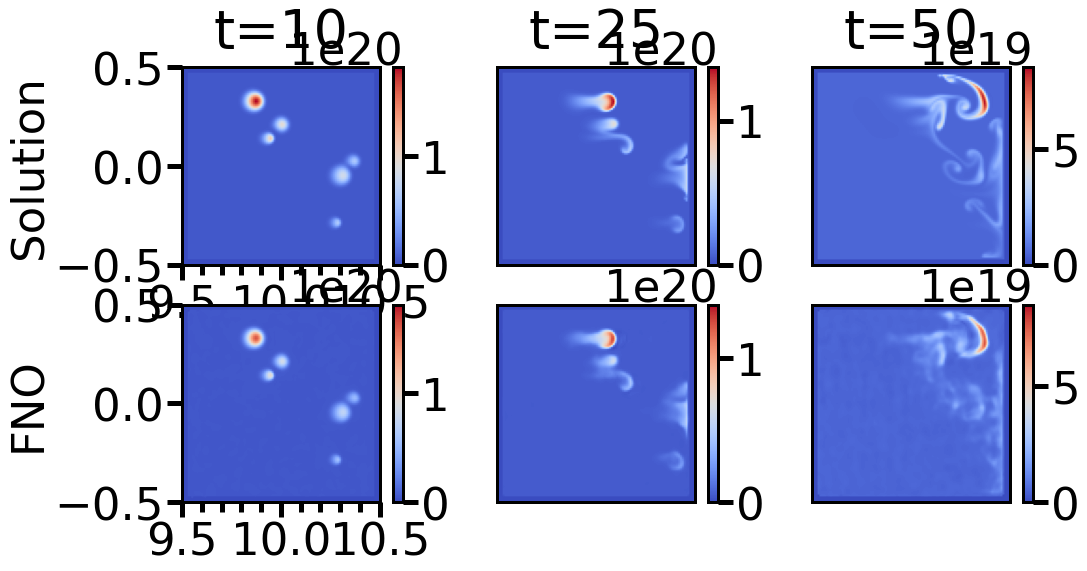

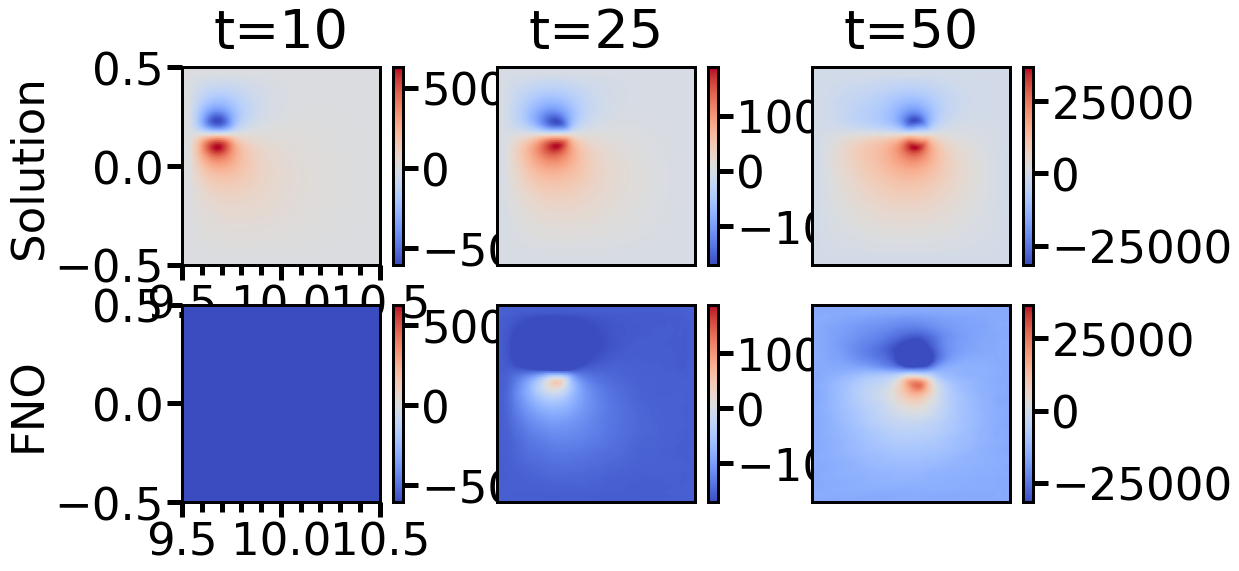

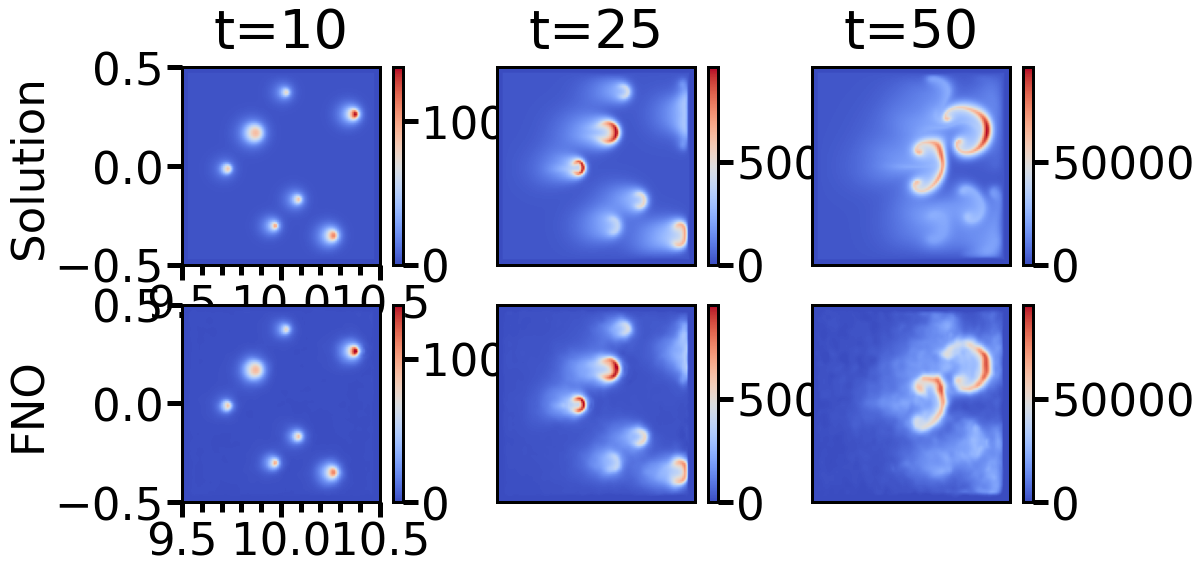

In [99]:
################################################################
# Preparing Data 
################################################################

errs = []
for field in dims:  
    print(field)
        
    if field == 'Phi':
        u_sol = np.load(data)['Phi'].astype(np.float32)   / 1e5
    elif field == 'T':
        u_sol = np.load(data)['T'].astype(np.float32)     / 1e6
    elif field == 'rho':
        u_sol = np.load(data)['rho'].astype(np.float32)   / 1e20

    if configuration['Log Normalisation'] == 'Yes':
        u_sol = np.log(u_sol)

    u_sol = np.nan_to_num(u_sol)
    # u_sol = np.delete(u_sol, (11, 160, 222, 273, 303, 357, 620, 797, 983, 1275, 1391, 1458, 1554, 1600, 1613, 1888, 1937, 1946, 1959), axis=0)
    u_sol= np.delete(u_sol, (153, 229), axis=0) #Outlier T values

    x_grid = np.load(data)['Rgrid'][0,:].astype(np.float32)
    y_grid = np.load(data)['Zgrid'][:,0].astype(np.float32)
    t_grid = np.load(data)['time'].astype(np.float32)

    ntrain = 240
    ntest = 36
    S =106  # Grid Size

    #Extracting hyperparameters from the config dict
    modes = configuration['Modes']

    output_size = configuration['Step']
    batch_size = configuration['Batch Size']
    T_in = configuration['T_in']
    T = configuration['T_out']
    step = configuration['Step']
    num_vars = configuration['Variables']
    width_time = configuration['Width_time']
    width_vars = configuration['Width_vars']
    t1 = default_timer()

    #At this stage the data needs to be [Batch_Size, X, Y, T]

    np.random.shuffle(u_sol)
    u = torch.from_numpy(u_sol)
    u = u.permute(0, 2, 3, 1)

    #At this stage the data needs to be [Batch_Size, X, Y, T]

    train_a = u[:ntrain,:,:,:T_in]
    train_u = u[:ntrain,:,:,T_in:T+T_in]

    test_a = u[-ntest:,:,:,:T_in]
    test_u = u[-ntest:,:,:,T_in:T+T_in]


    #Normalising the train and test datasets with the preferred normalisation. 
    norm_strategy = configuration['Normalisation Strategy']

    if norm_strategy == 'Min-Max':
        a_normalizer = MinMax_Normalizer(train_a)
        y_normalizer = MinMax_Normalizer(train_u)

    if norm_strategy == 'Range':
        a_normalizer = RangeNormalizer(train_a)
        y_normalizer = RangeNormalizer(train_u)

    if norm_strategy == 'Gaussian':
        a_normalizer = GaussianNormalizer(train_a)
        y_normalizer = GaussianNormalizer(train_u)


    test_a = a_normalizer.encode(test_a)
    test_u_encoded = y_normalizer.encode(test_u)


    t2 = default_timer()
    print('preprocessing finished, time used:', t2-t1)

    ################################################################
    # training and evaluation
    ################################################################

    #Instantiating the Model. 
    # model = FNO(modes, modes, width)
    num_vars = 1
    model = FNO_multi(T_in, step, num_vars, modes, modes, width_vars, width_time)

    if field == 'rho':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_fundamental-mesh.pth', map_location=torch.device('cpu')))
    if field == 'Phi':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_some-locker.pth', map_location=torch.device('cpu')))
    if field == 'T':
        model.load_state_dict(torch.load(file_loc + '/Models/FNO_multi_blobs_covering-cube.pth', map_location=torch.device('cpu')))
    model.to(device)

    run.update_metadata({'Number of Params': int(model.count_params())})
    print("Number of model params : " + str(model.count_params()))

    if torch.cuda.is_available():
        y_normalizer.cuda()

    # Testing
    batch_size = 1
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a.unsqueeze(1), test_u_encoded.unsqueeze(1)), batch_size=1,
                                            shuffle=False)
    pred_set = torch.zeros(test_u.shape)
    index = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx, yy = xx.to(device), yy.to(device)
            # xx = additive_noise(xx)
            t1 = default_timer()
            for t in range(0, T, step):
                y = yy[..., t:t + step]
                out = model(xx)

                if t == 0:
                    pred = out
                else:
                    pred = torch.cat((pred, out), -1)

                xx = torch.cat((xx[..., step:], out), dim=-1)

            t2 = default_timer()
            # pred = y_normalizer.decode(pred)
            pred_set[index] = pred
            index += 1
            # print(t2 - t1)

    #Logging Metrics 
    MSE_error = (pred_set - test_u_encoded).pow(2).mean()
    MAE_error = torch.abs(pred_set - test_u_encoded).mean()
    # LP_error = loss / (ntest*T/step)
    # rel_error = torch.abs((pred_set - test_u_encoded)/test_u_encoded).mean() * 100 



    print('(MSE) Testing Error: %.3e' % (MSE_error))
    print('(MAE) Testing Error: %.3e' % (MAE_error))
    # print('(LP) Testing Error: %.3e' % (LP_error))
    # print('(MAPE) Testing Error %.3e' % (rel_error))
    # print('(NMSE) Testing Error %.3e' % (nmse))
    # print('(NRMSE) Testing Error %.3e' % (nrmse))

    # run.update_metadata({'MSE Test Error': float(MSE_error),
    #                     'MAE Test Error': float(MAE_error),
    #                     'LP Test Error': float(LP_error)
    #                     })

    pred_set_encoded = pred_set
    pred_set = y_normalizer.decode(pred_set.to(device)).cpu()
    pred_set_scaled = pred_set
    test_u_scaled = test_u

    nmse = ((pred_set_scaled - test_u_scaled).pow(2).mean() / test_u_scaled.pow(2).mean())
    print('(NMSE) Testing Error %.3e' % (nmse))



    if configuration["Physics Normalisation"] == 'Yes':
        if field == 'rho':
            pred_set = pred_set * 1e20
            test_u = test_u * 1e20
        if field == 'Phi':
            pred_set = pred_set * 1e5
            test_u = test_u * 1e5
        if field == 'T':
            pred_set= pred_set * 1e6
            test_u = test_u * 1e6

    #Plotting the comparison plots

    idx = np.random.randint(0,ntest) 
    # idx = 3
    idx = 15

    if configuration['Log Normalisation'] == 'Yes':
        test_u = torch.exp(test_u)
        pred_set = torch.exp(pred_set)

    u_field = test_u[idx]

    v_min_1 = torch.min(u_field[:,:,0])
    v_max_1 = torch.max(u_field[:,:,0])

    v_min_2 = torch.min(u_field[:, :, int(T/2)])
    v_max_2 = torch.max(u_field[:, :, int(T/2)])

    v_min_3 = torch.min(u_field[:, :, -1])
    v_max_3 = torch.max(u_field[:, :, -1])

    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(2,3,1)
    pcm =ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    # ax.title.set_text('Initial')
    ax.title.set_text('t='+ str(T_in))
    ax.set_ylabel('Solution')
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,2)
    pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    # ax.title.set_text('Middle')
    ax.title.set_text('t='+ str(int((T+T_in)/2)))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,3)
    pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    # ax.title.set_text('Final')
    ax.title.set_text('t='+str(T+T_in))
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    u_field = pred_set[idx]

    ax = fig.add_subplot(2,3,4)
    pcm = ax.imshow(u_field[:,:,0], cmap=cm.coolwarm, extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_1, vmax=v_max_1)
    ax.set_ylabel('FNO')

    fig.colorbar(pcm, pad=0.05)

    ax = fig.add_subplot(2,3,5)
    pcm = ax.imshow(u_field[:,:,int(T/2)], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_2, vmax=v_max_2)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)


    ax = fig.add_subplot(2,3,6)
    pcm = ax.imshow(u_field[:,:,-1], cmap=cm.coolwarm,  extent=[9.5, 10.5, -0.5, 0.5], vmin=v_min_3, vmax=v_max_3)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    fig.colorbar(pcm, pad=0.05)

    #Plotting the error growth across time.
    err = [] 

    for ii in range(T):
        err.append((pred_set_scaled[...,ii] - test_u_scaled[...,ii]).pow(2).mean() / test_u_scaled.pow(2).mean())
    print(test_u_scaled.pow(2).mean())
    err = np.asarray(err)
    errs.append(err)

In [100]:
# plt.plot(np.arange(T_in, T_in + T), err, label=field + ' - solo', alpha=0.8,  color = 'tab:brown')
# plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density', alpha=0.8,  color = 'tab:blue')
# # plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential', alpha=0.8,  color = 'tab:orange')
# # plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp', alpha=0.8,  color = 'tab:green')
# # plt.plot(np.arange(T_in, T_in + T), (err_rho+err_phi+err_T), label='Cumulative', alpha=0.8,  color = 'tab:red', ls='--')
# plt.legend()
# plt.xlabel('Time Steps')
# plt.ylabel('NMAE ')

In [101]:
err_rho_solo, err_phi_solo, err_T_solo = errs[0], errs[1], errs[2]

Text(0, 0.5, 'NMSE ')

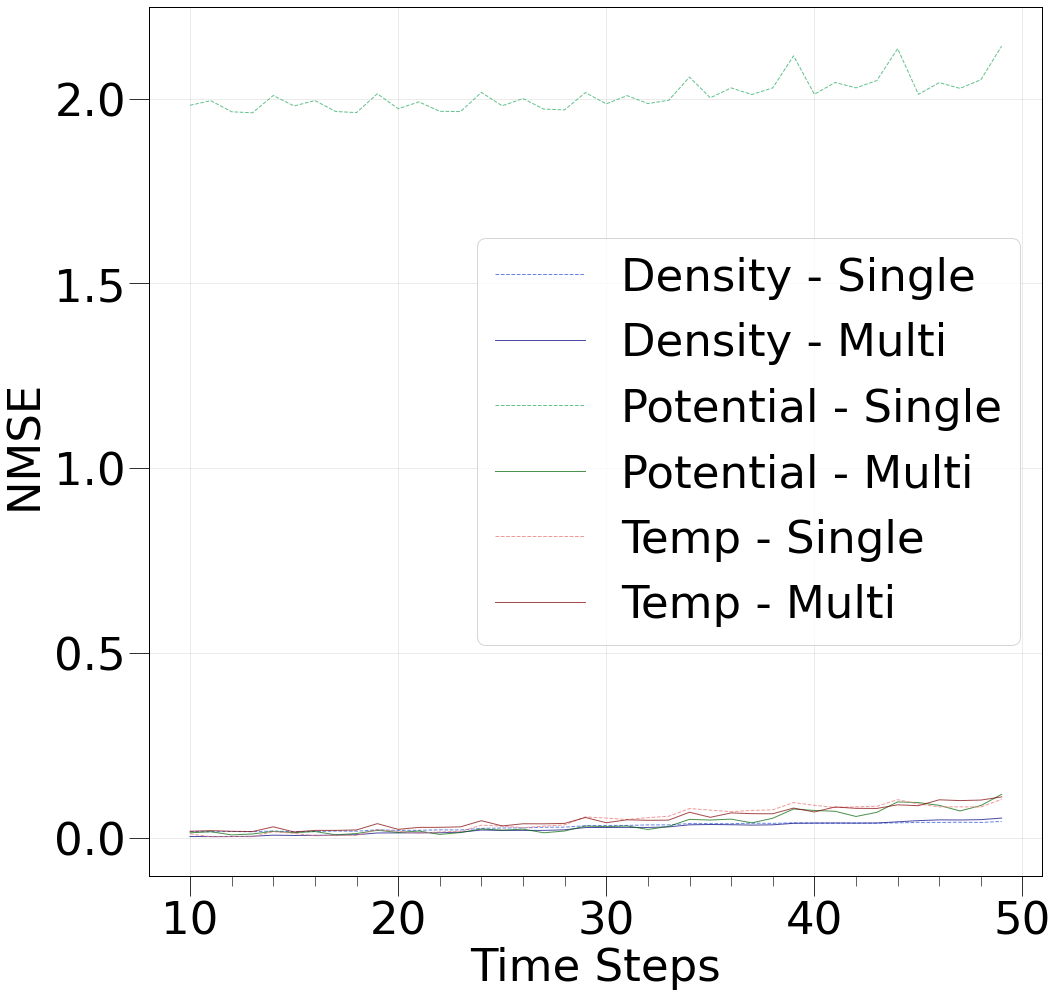

In [102]:
import matplotlib as mpl

plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '-'
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=45
mpl.rcParams['figure.figsize']=(16,16)
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 1
mpl.rcParams['axes.titlepad'] = 30
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['ytick.major.size'] = 20
plt.rcParams['xtick.minor.size'] = 10.0
plt.rcParams['ytick.minor.size'] = 10.0
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.minor.width'] = 0.6
mpl.rcParams['lines.linewidth'] = 1
plt.figure()
plt.grid()
plt.plot(np.arange(T_in, T_in + T), err_rho_solo, label='Density - Single', alpha=0.8,  color = 'royalblue', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density - Multi', alpha=0.7,  color = 'navy')
plt.plot(np.arange(T_in, T_in + T), err_phi_solo, label='Potential - Single', alpha=0.8,  color = 'mediumseagreen', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential - Multi', alpha=0.7,  color = 'darkgreen')
plt.plot(np.arange(T_in, T_in + T), err_T_solo, label='Temp - Single', alpha=0.8,  color = 'lightcoral', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp - Multi', alpha=0.7,  color = 'maroon')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('NMSE ')

# plt.savefig("multiblobs_error_growth.pdf", bbox_inches='tight')
# plt.savefig("multiblobs_error_growth.svg", bbox_inches='tight')

Text(0, 0.5, 'NMSE ')

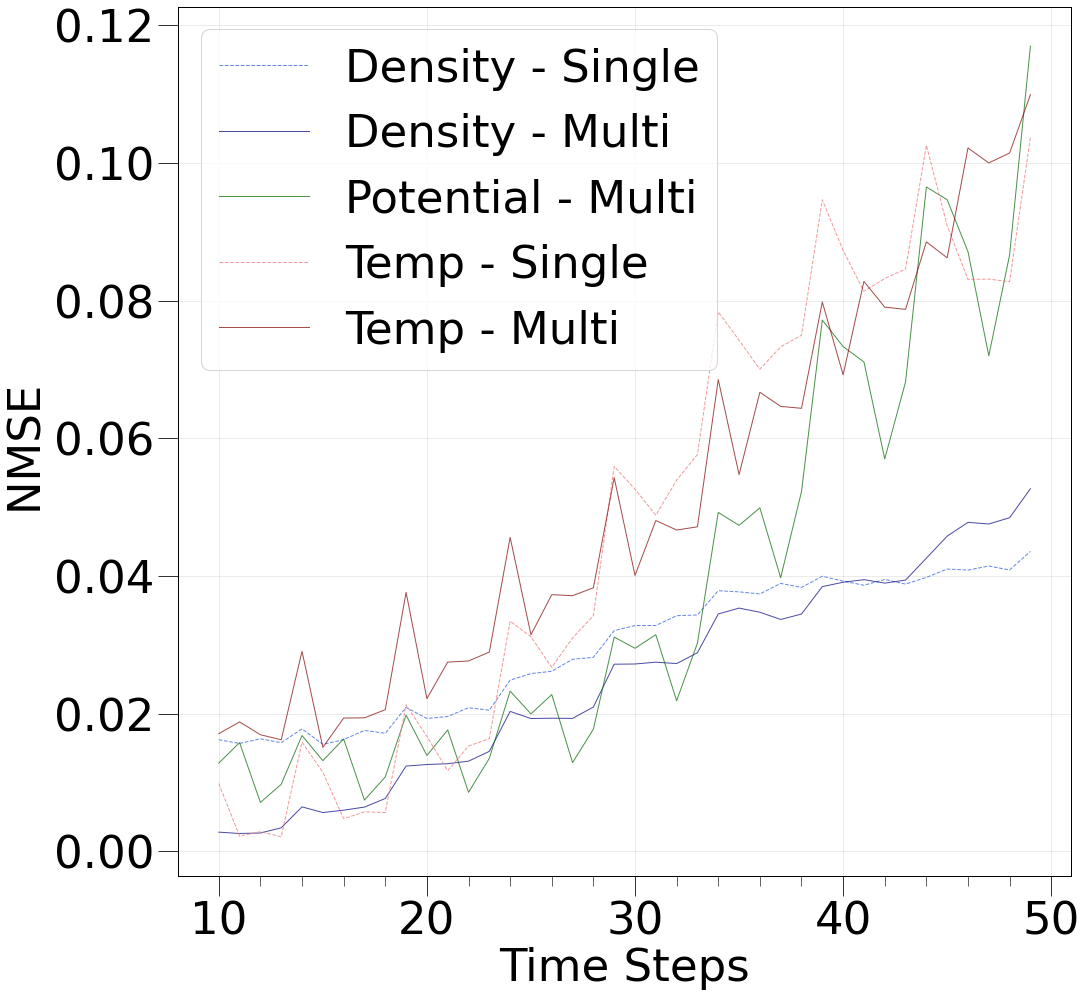

In [103]:
import matplotlib as mpl

plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '-'
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['font.size']=45
mpl.rcParams['figure.figsize']=(16,16)
mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 1
mpl.rcParams['axes.titlepad'] = 30
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['ytick.major.size'] = 20
plt.rcParams['xtick.minor.size'] = 10.0
plt.rcParams['ytick.minor.size'] = 10.0
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.minor.width'] = 0.6
mpl.rcParams['lines.linewidth'] = 1
plt.figure()
plt.grid()
plt.plot(np.arange(T_in, T_in + T), err_rho_solo, label='Density - Single', alpha=0.8,  color = 'royalblue', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_rho, label='Density - Multi', alpha=0.7,  color = 'navy')
# plt.plot(np.arange(T_in, T_in + T), err_phi_solo, label='Potential - Single', alpha=0.8,  color = 'mediumseagreen', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_phi, label='Potential - Multi', alpha=0.7,  color = 'darkgreen')
plt.plot(np.arange(T_in, T_in + T), err_T_solo, label='Temp - Single', alpha=0.8,  color = 'lightcoral', ls='--')
plt.plot(np.arange(T_in, T_in + T), err_T, label='Temp - Multi', alpha=0.7,  color = 'maroon')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('NMSE ')

# plt.savefig("multiblobs_error_growth.pdf", bbox_inches='tight')
# plt.savefig("multiblobs_error_growth.svg", bbox_inches='tight')